# W207 Final Project: American Sign Language Recognition
---
### **Team:** Elizabeth Khan, Jagan Lakshmipathy, Jerry Hsiao, Kumar Narayanan





*** Last updated on 12/2/2021


##  1. Motivation and Initial Setup
<hr>

### Research Question: Can we accurately classify American Sign Language images?

### Project Motivation
American Sign Language (ASL) is a prevalent language amongst the Deaf community where they use hand motions and facial expressions to communicate. Per the Communication Service for the Deaf, there are nearly one million ASL users (Waterfield, 2019). Other estimates suggest that there are approximately **250,000 to 500,000** ASL speakers. The limited number of primary ASL speakers makes it especially challenging for communicating outside of the Deaf community. In fact, Newsweek article reports that “**72%** of families do not sign with their deaf children” (Waterfield, 2019). Thus, there is a need to remove the communication barrier between people who use sign language and those who use spoken language.


### Existing Research

To solve the ASL problem there is promising research in the Computer Vision and Machine Translation fields of machine learning. Two notable studies that provided inspiration to our project are as follow:

1. ASL Image Classification [(Stanford 2016 Study)](http://cs231n.stanford.edu/reports/2016/pdfs/214_Report.pdf)
2. ASL Motion Sensor Data Classification [(University of North Florida 2014 study)](https://)


<hr>


### Google Drive Access

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

<hr>

### Imports

In [2]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import image
import glob
import cv2
import os
import zipfile
import pyarrow as pa
import pyarrow.parquet as pq
import gc
import time
import sys

# import model frameworks and related preprocessing packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from tensorflow.keras.applications import vgg16
import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import timeit

base_path = pathlib.Path('/content/drive/MyDrive/W207/Data/')


sklearn.__version__

Using TensorFlow backend.


'1.0.1'

<hr>

## Helper Methods

In [3]:
def timeit(f):
    def wrap(*args, **kw):
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        print(f'func:{f.__name__} args:[{args}, {kw}] took: {te-ts:2.4f} sec')        
        return result
    return wrap

def plot_image(vector_image, dimension=(200,200)):
  plt.rc('image', cmap='gray')
  plt.imshow(vector_image.reshape(*dimension))
  plt.show()

<hr>

## Load Data

In [4]:
@timeit
def load():
  table = pq.read_table('X_train.pq')
  table = table.to_pandas().to_numpy()
  return table

X_train = load()
y_train = np.array(pd.read_csv('X_labels.csv'))

func:load args:[(), {}] took: 14.8078 sec


<hr>

# 2. Data & Exploratory Data Analysis

The dataset was sourced from Akash Nagaraj’s Kaggle repository
which can be found [here.](https://www.kaggle.com/grassknoted/asl-alphabet)

The dataset we will be using consists of 87,000 images with 200 x 200 pixels. In total there are 29 classes including the American Alphabet letters A through X, and 3 additional classes: SPACE, DELETE, and NOTHING. Note: NOTHING is an image of the background without any ASL signing (i.e. just an empty room). This can be used to help distinguish between the background and the hand. 


In this section we conduct an exploratory data analysis of the ASL image data to understand the image data and to help inform our image preprocessing.

First we check the sizes of the training data, we expect to see 87,000 training examples in total.

In [5]:
# check the sizes of the trainining data 
print("Size of X_train:", len(X_train))
print("Size of y_train:", len(y_train))
print("Number of X_train features (for 200x200 pixel images):", len(X_train[0]))

Size of X_train: 87000
Size of y_train: 87000
Number of X_train features (for 200x200 pixel images): 40000


Next, we create a 6 x 5 grid showing examples of the 29 different signs from the training data in their original state.


**Choose a random image to display for each sign**

- In order to check the quality of the images from the source we randomly select an image for each of the 29 characters (26 letters, "nothing", "space", and delete")
- In addition to displaying the randomly selected image for each character we also run each of these images through "cv.calcHist()" that provides the RGB values for pixels for each of thes images. The histogram provides a visual way to see image quality by looking at the primary color distribution. The call to is cv2.calcHist([image], [channel], mask, [range]), where [image] is an image list (read using cv2.imread()), [channel] is the R(0), G(1), B(2) values list, mask is set to None, and [range] is the list of pixel value (usually 256).
- We display the histogram of the RGB values of the pixels few steps later.
- The following variables are used:
*raw_image_list:* This stores each of the images in its raw form that we used for display. This variable is later used to generate the gray scale versions of these images

*cn_hist_list:* Here n varies between 0 and 2, for each of the channels (R, G, B), and stores the histogram values of pixels.

*label_ind_dict:* This is a dictionary data structure that's indexed by the label (of the character) and the index points to the randomly selected image number for each character.

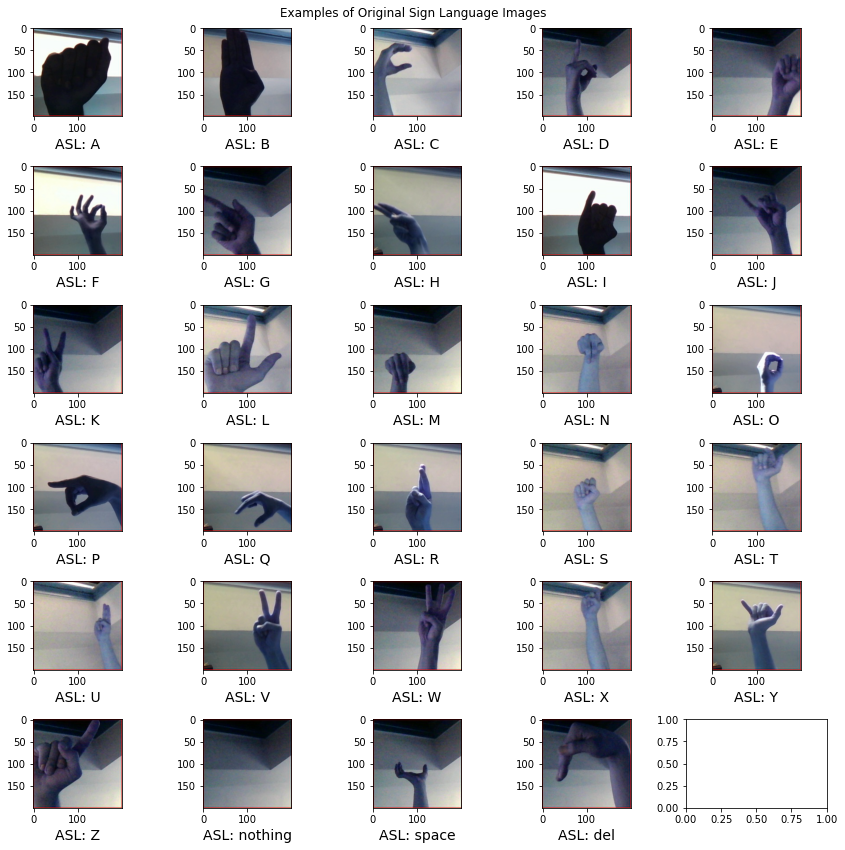

func:plot_signs_color args:[(), {}] took: 112.2395 sec


In [6]:
@timeit
def plot_signs_color():
    path='/home/jupyter/images/asl_alphabet_train/asl_alphabet_train/'

    X_train_imgs = []
    y_train_imgs = []

    labels = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P",
              "Q","R","S","T","U","V","W","X","Y","Z","nothing","space", "del"]

    fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(12, 12))
    row = 0
    col = 0
    raw_image_list = []
    c0_hist_list = []
    c1_hist_list = []
    c2_hist_list = []

    label_ind_dict = {} # dictionary to hold the label to index mapping

    for label in labels:
        # get a list of all images (.jpg files) in a directory using glob.glob
        examples = glob.glob(path+label+"/*.jpg")
        img_cnt = 0 # for each label start with img_cnt set to 0
        print_flag = 1 # randomly select image 
        for image in examples:
            y_train_imgs.append(label)
            image1 = cv2.imread(image)
            if print_flag == img_cnt: 
                raw_image_list.append(image1) # add the image to the raw_image_list
                label_ind_dict[label] = img_cnt - 1 # save the index for that label
                # calculate the RGB values for the image and append to a list
                c0_hist_list.append(cv2.calcHist([image1], [0], None, [256], 
                                                 [0,256]))
                c1_hist_list.append(cv2.calcHist([image1], [1], None, [256], 
                                                 [0,256]))
                c2_hist_list.append(cv2.calcHist([image1], [2], None, [256], 
                                                 [0,256]))
                ax = axes[row, col]
                ax.imshow(image1, cmap="gray") 
                ax.set_xlabel('ASL: '+label, fontsize=14) 
                col += 1
                if col % 5 == 0:
                    row += 1
                    col = 0
            img_cnt += 1
            image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
            # gaussian blur
            image1 = cv2.GaussianBlur(image1.reshape(200,200), (5,5),0)
            image1 = cv2.Canny(image=image1.reshape(200,200), threshold1=100, 
                               threshold2=200)
            im_array = np.asarray(image1).reshape((200,200))
            X_train_imgs.append(im_array.flatten())
    plt.suptitle('Examples of Original Sign Language Images')
    # print(examples)
    fig.tight_layout()
    plt.show()
    return X_train_imgs, y_train_imgs, labels, c0_hist_list, c1_hist_list, c2_hist_list, label_ind_dict, raw_image_list

X_train_imgs, y_train_imgs, labels, c0_hist_list, c1_hist_list, c2_hist_list, label_ind_dict, raw_image_list = plot_signs_color()

We then create a 6 x 5 grid showing examples of the 29 different signs in grayscale.

**Grayscale images corresponding to the color images**

In this section we pick the gray scale image corresponding to the image we stored in *raw_image_list* variable earlier. We do this by looking at the index for each character in the variable *label_ind_dict* and matching that index to the index in the X_train variable, which holds all the gray scale images.

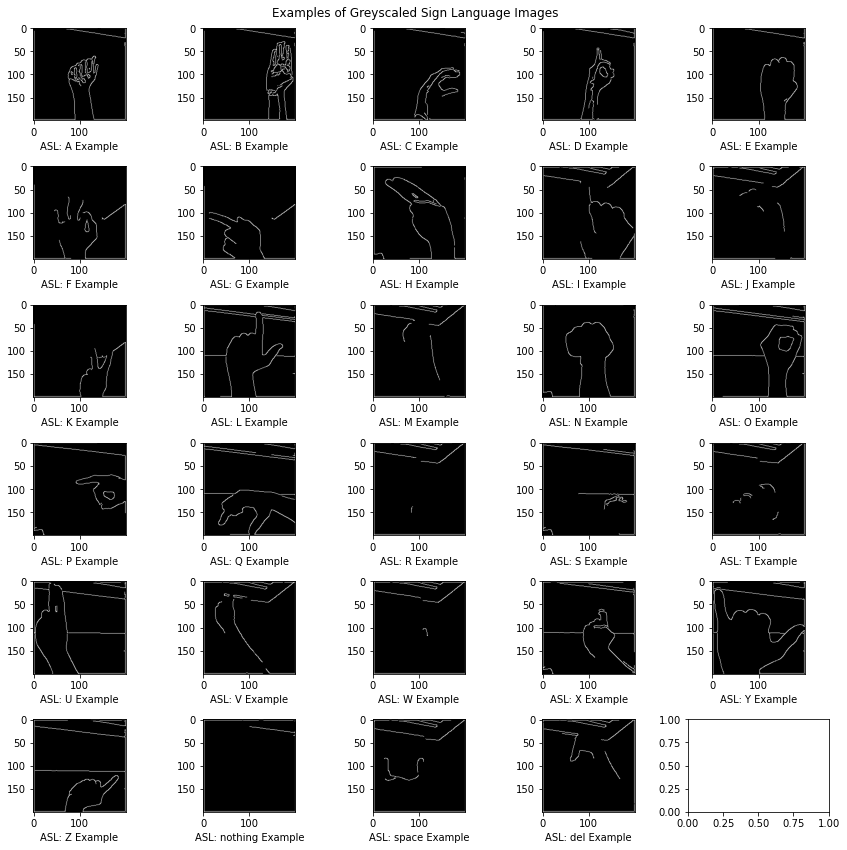

func:plot_greyscaled_signs args:[(), {}] took: 2.9446 sec


In [7]:
X_train_imgs = np.array(X_train_imgs)
y_train_imgs = np.array(y_train_imgs)

@timeit
def plot_greyscaled_signs():
    image_index_list = [] # init list to add digit example indexes to
    # for each label find indices in y_train for that label and pick that 
    # index that corresponds to label index that was printed earlier.
    for label in labels:
        label_ind = np.where(y_train_imgs==label)[0][label_ind_dict[label]]
        image_index_list.append(label_ind)

    plt.rc('image', cmap='gray')
    fig, ax = plt.subplots(6, 5, figsize=(12,12))

    counter = 0 # counter to be used for image index

    for i in range(6):
        for num in range(5):
            if counter < 29:
                ind = image_index_list[counter]
                # Displaying image on correct subplot
                ax[i, num].imshow(X_train_imgs[ind].reshape(200,200))
                ax[i,num].set_xlabel('ASL: '+y_train_imgs[ind]+' Example')
                counter += 1
    plt.suptitle('Examples of Greyscaled Sign Language Images')
    fig.tight_layout()
    plt.show()
    
plot_greyscaled_signs()

This is a plot of the distribution of pixels across the color channels red, blue, green (RGB) in the original images displayed earlier.


**RGB Values Plot**

This uses the variables c0_hist_list, c1_hist_list, and c2_hist_list to get the RGB histograms for each of the picture displayed earlier, in color. The image is laid out as 9 images per row, to fill in up to 29 images.

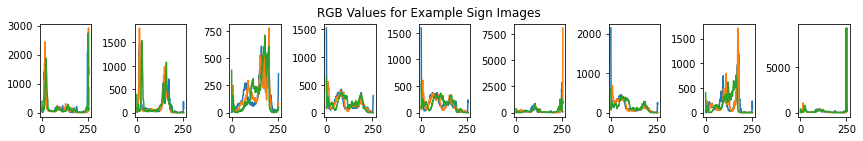

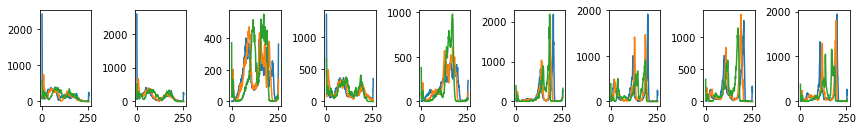

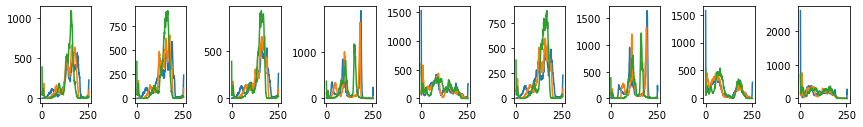

func:plot_rgb_hists args:[(), {}] took: 2.4814 sec


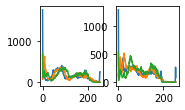

In [8]:
@timeit
def plot_rgb_hists():
    pos = 790 # control the position of where we want to print the image
    plt.figure(figsize=(12,12))
    plt.suptitle('RGB Values for Example Sign Images')
    for i in range(len(raw_image_list)):
        pos += 1 # start with position 791: 9 images per row, starting from col 1
        plt.subplot(pos), plt.plot(c0_hist_list[i]), plt.plot(c1_hist_list[i]), 
        plt.plot(c2_hist_list[i])
        if pos == 799: # when 9 pictures have been accumulated
            pos = 790  # reset to 790, draw 
            plt.tight_layout() 
            plt.show() # draw the 9 pictures
            plt.figure(figsize=(12,12)) # reinit the drawing space
plot_rgb_hists()

In [9]:
# Clear memory
del X_train_imgs, y_train_imgs, labels, c0_hist_list, c1_hist_list, c2_hist_list, label_ind_dict, raw_image_list

<hr>

## 3. Pre-processing

In the cleanup section we will pre-process the ASL sign language images to improve the performance of our model. This includes Computer Vision techniques such as applying Guassian Blur, Canny Edge Detection, and reducing the dimensionity of our data since we have 400,000 features. See images plots below to demonstrate the image transformations applied.

func:plot_transformations args:[(), {}] took: 0.0572 sec


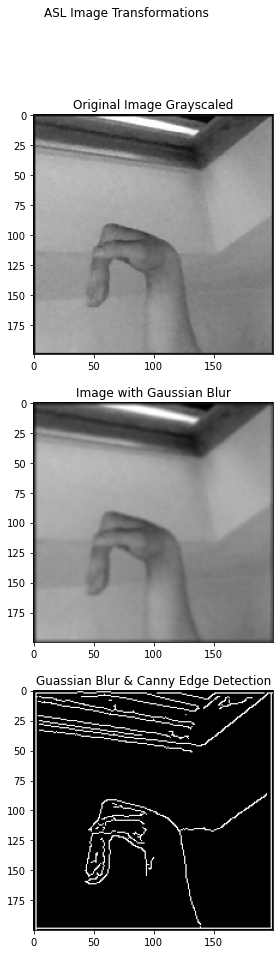

In [10]:
@timeit
def plot_transformations(img=X_train[5]):
  # reshaping image to 200x200
  img = img.reshape(200,200)
  # display image as grayscale
  plt.rc('image', cmap='gray')
  # initiate subplots for three plots
  fig, axs = plt.subplots(3,figsize=(30,15))
  # add title and subplot title
  fig.suptitle('ASL Image Transformations')
  axs[0].set_title('Original Image Grayscaled')
  # display grayscaled image
  axs[0].imshow(img)
  # apply guassian blur to the image with (5,5) kernel
  img = cv2.GaussianBlur(img, (5,5),0)
  # add subplot title
  axs[1].set_title('Image with Gaussian Blur')
  # diplay guassian blur image
  axs[1].imshow(img)
  # add subplot title
  axs[2].set_title('Guassian Blur & Canny Edge Detection')
  # apply canny edge detection
  img = cv2.Canny(np.uint8(img), threshold1=20, threshold2=60)
  # display image with gaussian blur and canny applied
  axs[2].imshow(img)

plot_transformations()

### 3.1 Guassian Blur
Gaussian blur applies image smoothing (blur) by using a filter kernel and allows us to remove noise from an image. In this case, we are using OpenCV's Gussain blur implementation with a (5,5) kernel to apply a reasonable amount of blur prior to applying the Canny Edge detection.

In [11]:
@timeit
# This is a guassian blur which will add noise to help make the edges more distinguishable
def blur(array, filter_size =(5,5)):
    return  np.array([cv2.GaussianBlur(i.reshape(200,200), filter_size, 0).flatten() for i in array])

# Transform X_train using gaussian blur
X_train = blur(X_train)

func:blur args:[(array([[31, 32, 29, ..., 27, 33, 27],
       [30, 33, 29, ..., 28, 32, 26],
       [30, 33, 29, ..., 28, 34, 27],
       ...,
       [32, 31, 29, ..., 29, 28, 31],
       [35, 34, 31, ..., 29, 28, 30],
       [32, 33, 29, ..., 28, 28, 31]], dtype=uint8),), {}] took: 20.5351 sec



### 3.2 Canny Edge Detection
This is the function that includes OpenCV’s canny edge detection algorithm which helps identify the edges of the hands that are signing in ASL in our images. There are two thresholds an upper and lower, which determine what is considered an edge. This works well in scenarios where there is not a lot of noise in the background which is the case with the ASL images for this project.

In [12]:
# This canny transformation helps with edge detection of the hands as pictured in the example above
@timeit
def canny_transform(array, thresh1=100, thresh2=200):
    return  np.array([cv2.Canny(i.reshape(200,200), threshold1=thresh1,threshold2=thresh2).flatten() for i in array])

# Transform X_train using canny
X_train = canny_transform(X_train)
# Rescale grayscale values to [0,1]
#X_train = X_train/255.0

func:canny_transform args:[(array([[31, 33, 36, ..., 47, 43, 40],
       [31, 33, 35, ..., 52, 47, 43],
       [32, 33, 36, ..., 40, 38, 37],
       ...,
       [31, 33, 37, ..., 81, 71, 64],
       [33, 34, 37, ..., 80, 70, 63],
       [32, 33, 36, ..., 80, 69, 63]], dtype=uint8),), {}] took: 23.2447 sec


### 3.4 Shuffle Data and Split into the Training and Test sets

We are shuffling the data to ensure that we do not have too many of any single alphabet ASL sign in our training data verus test set. Next we use Sklearn's `train_test_split` to include 80% of our data in the training set and 20% of our data in the test set.

In [13]:
# set randomization seed to make results reproducible
np.random.seed(18)


#Shuffle the dataset
X_train,y_train = shuffle(X_train,y_train,random_state=18)

# train test split to
x_train,x_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2, random_state=18)

# Calculating standard deviation and mean for standardizing the data in the next step

std = np.std(X_train)
mean = np.std(X_train)

# deleting to clear out 4 gb in memory
del X_train

### 3.5 Standardize Image Data

The default image pixel values are from 0 to 255. We are normalizing the image pixels by subtracting the mean and dividing by the standard deviation. This is a preprocessing step prior to using Principal Component Analysis for dimensionality reduction. 

*Note: here we are standardizing 1,000 records at a time due to memory constraints on GCP.*

In [14]:
@timeit
def standardize(data=x_train, start_=0, end_ = 999, start2_=0, end2_=999):
  mean_ = mean
  std_ = std
  # Define initial start and end
  start1 = start_
  end1 = end_
  start = start2_
  end = end2_
  # create an empty numpy array based on the existing shape of the dataset
  scaled_data = np.empty(data.shape,dtype=np.float64)
  # chunk size = 1000 records
  size = np.ceil(len(scaled_data)/1000)
  # looping through a 1000 records at a time and returning the standardized data by subtracting the mean and dividing by the standard deviation
  for chunk in range(int(size)):
    scaled_data[start:end] = (((data[start1:end1]-mean_)/std)).astype(np.float64)
    # scaled_data[start:end] = (data[start1:end1]/255.0).astype(np.float32)
    # updating start and end for next iteration
    start = end
    start1 = end1
    if end1 != np.ceil(len(scaled_data)/1000)*1000-1001:
      end1 = end1 + (1000)
      end = end + (1000)
    else:
      end1 = end1 + (len(scaled_data)%1000)
      end = end + (len(scaled_data)%1000)
  scaled_data = scaled_data.astype(np.float64)
  return scaled_data

# standardizing training images
x_train = standardize()

# standardizing test images

x_test = standardize(data=x_test)


func:standardize args:[(), {}] took: 34.4116 sec
func:standardize args:[(), {'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}] took: 8.5133 sec


### 3.6 Dimensionality Reduction

In total we have over 400,000 features as we are using a 200x200 pixel image which makes most Machine Learning algorithms really inefficient and computationally expensive when handling such a sparse dataset. To combat this, we employ Principal Component Analysis (PCA)  which is a dimensionality reduction technique that transforms features into principal components which explain most of the information (variance) from the original dataset. In this case, we are using just the first 1000 test examples because of limitation of our GCP compute and memory and found that it actually does a reasonable job. 

In [15]:
@timeit
def pca_transform(train_data = x_train, data=x_train,  explainability=.80,size=1000,svd_solver='full', start_=0, end_ = 999, start2_=0, end2_=999):
  np.random.seed(18)
  pca = PCA(explainability, random_state=18)
  pca.fit(train_data[:size])
  components = len(pca.explained_variance_)
  # Define intial start and end
  start1 = start_
  end1 = end_
  start = start2_
  end = end2_
  pca_data = np.empty((len(data),components),dtype=np.float64)
  # chunk size = 1000 records
  size = np.ceil(len(pca_data)/1000)

  for chunk in range(int(size)):
    #print(start1,end1)
    pca_data[start:end] = pca.transform(data[start1:end1])
    start = end
    start1 = end1
    if end1 != np.ceil(len(pca_data)/1000)*1000-1001:
      end1 = end1 + (1000)
      end = end + (1000)
    else:
      end1 = end1 + (len(pca_data)%1000)
      end = end + (len(pca_data)%1000)
  pca_data = np.nan_to_num(pca_data)
  return pca_data

# applying pca to train data
pca_train = pca_transform()

# applying pca to test data

pca_test = pca_transform(data=x_test)


func:pca_transform args:[(), {}] took: 44.9437 sec
func:pca_transform args:[(), {'data': array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])}] took: 17.0023 sec


In [16]:
# clearing out 4 gb of memory
del x_train
del x_test

We are encoding the labels (encoding to 0 to 28) so that they can be passed into the XGBoost and LogisticRegression models.

In [17]:
# encoding y labels for xgboost and logistic regression algorithm
def label_encode(train_labels, test_labels):
    le = LabelEncoder()
    le.fit(train_labels)
    print(len(le.classes_))
    train = le.transform(train_labels)
    test = le.transform(test_labels)
    return train, test

train_labels, test_labels = label_encode(y_train,y_test)

29


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 4. Approach & Experiments

In this section we will use the pre-processed image data to train Naive Bayes, Logistic Regression, XGBoost, and Convolutional Neural Network (CNN). We will then evaluate the models using classification performance metrics such as Accuracy, Precision, F1 Score, and the Receiver operating characteristic curve (ROC) [5].

1. Accuracy: The proportion of correctly labeled sign language images

$ Accuracy=\frac{TP+TN}{FP+FN\ +\ TP\ +\ TN}$

2. Precision: The proportion of postive samples (correctly classified sign language images) out of the the total classified as positive (True Positive and False Positive).

$Precision=\frac{TP}{TP\ +FP}$

3. F1 Score: The F1 Score considers both precision and recall  

$F1\ Score=2*\ \frac{precision\ \ *\ recall}{precision\ +\ recall}$

4. Receiver operating characteristic(ROC) curve: The ROC curve shows provides an overview of the performance of the classification model across various classification thresholds. This graph will have the False Positive Rate on the x-axis and the True Positive Rate on the y-axis. We will use the sklearn implementation of the `roc_curve` which is more suitable for binary classification problems. We will have to convert the labels to true binary labels for plotting an ROC curve for each of the 29 classes.

In [18]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

inv_labels_dict = {v: k for k, v in labels_dict.items()}

all_labels = list(labels_dict.keys())

# empty list to store model results
model_results = {"model_name":[], "f1_score":[], "accuracy":[], "labels_f1_score":[],"labels_precision":[]}


### Helper Functions for ML Model Evaluation

In [19]:
# Function that returns f1, accuracy, and precision scores
def get_model_metrics(test_data,test_labels, model):
    # predicted labels from test data
    preds = model.predict(test_data)
    # F1 Score
    f1 = metrics.f1_score(test_labels, preds, average='weighted')
    # Accuracy
    accuracy = metrics.accuracy_score(test_labels, preds)
    # Precision
    precision = metrics.precision_score(test_labels, preds, average='weighted')
    
    # Print out scores
    print("******Weighted Metrics********")
    print('    F1-score: {:.4f}\n'.format(f1))
    print('    Accuracy: {:.4f}\n'.format(accuracy))
    print('    Precision: {:.4f}'.format(precision))
    
    # get scores for each label
    f1_l = metrics.f1_score(test_labels, preds, average=None)
    precision_l = metrics.precision_score(test_labels, preds, average=None)
    
    # Print out scores
    print("\n******Per-label Metrics********")
    print("F1 score:")
    print(f1_l)
    print("Precision:")
    print(precision_l)
    
    return f1, accuracy, precision, f1_l, precision_l

In [20]:
# Function that plots a confusion matrix for the model
def plot_confusion_matrix(test_data, test_labels, model, model_name='XGBoost', col=None):
    if col == None:
        # plot confusion matrix
        fig, ax = plt.subplots(figsize=(15, 15))
        metrics.plot_confusion_matrix(model, test_data, test_labels,cmap=plt.cm.Blues, ax=ax) 
        # Display title
        plt.title("{} Model Confusion Matrix".format(model_name), size = 15)

    else: 
        # dataframe of all models results
        df = pd.DataFrame(model_results)
        # get accuracy value
        accuracy = df[df['model_name']==col]['accuracy'].item()
        # plot confusion matrix
        fig, ax = plt.subplots(figsize=(15, 15))
        metrics.plot_confusion_matrix(model, test_data, test_labels,cmap=plt.cm.Blues, ax=ax)  
        # Display title
        plt.title('{} Model Confusion Matrix: \nOverall Accuracy = {}'.format(model_name, accuracy), size = 15)
       

In [21]:
# Function that plots the ROC curve for the model
def plot_roc_curve(y_labels,test_data, model, classes=29, model_name='XGBoost', string_=False):
    from sklearn.metrics import precision_recall_curve, roc_curve
    # set empty dictionaries for storing values
    fpr = dict()
    tpr = dict()
    
    #get probability scores for each label
    y_score = model.predict_proba(test_data)
    
    # Create 20x20 figure size
    plt.figure(figsize=(20,20))
    if string_==False:
        # Loop through labels 0 through 28
        for clsi in range(classes):
            fpr, tpr, _ = metrics.roc_curve(np.where(y_labels==clsi,1,0), y_score[:,clsi])
            plt.plot(fpr, tpr, lw=2, label='class {}'.format(all_labels[clsi]))
        plt.xlim(0.0, 0.02)  
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.legend(loc="lower right")
        plt.title(model_name + " Model: ROC Curves", size = 15)
        plt.show()
    elif string_==True:
        for clsi in range(classes):
            fpr, tpr, _ = metrics.roc_curve(np.where(y_labels==all_labels[clsi],1,0), y_score[:,clsi])
            plt.plot(fpr, tpr, lw=2, label='class {}'.format(all_labels[clsi]))
        plt.xlim(0.0, 0.02)  
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.legend(loc="lower right")
        plt.title(model_name + " Model: ROC Curves", size = 15)
        plt.show()
        
        

In [22]:
# Function that outputs a final summary table of metrics from all the models

def create_final_summary_table(labels= all_labels, num_labels=29, metric = 'labels_f1_score', title = 'Label F1 Scores For Various Models'):
    import seaborn as sns
    models = model_results['model_name']
    scores = pd.DataFrame()
    for i in range(len(models)):
        # create an array of all f1 scores for all labels
        array = np.array(pd.DataFrame(model_results)[metric][i]).reshape(num_labels,1)
        df = pd.DataFrame(array, index= labels, columns=[models[i]])
        if i ==0:
            scores = scores.append(df)
        else:
            scores = scores.merge(df,how='outer', left_index=True, right_index=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(scores,annot=True, ax=ax)
    plt.title(title, size=15)
    #return scores
             

<hr>

### 4.1 Multinominal Naive Bayes

Multinominal Naive Bayes is a supervised learning model that implements the Naive Bayes algorithm for multinomially distributed data (ideal for multi-class classifaction).

#### Tuning parameter: Alpha

Alpha is an additive Laplace/Lidstone smoothing parameter. [SKLearn, 2021](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) When leveraging MNB, multiple alpha values were selected between 0 to 500 to identify an optimzed value.

#### Scaling

Scaling normalizes the datasets into the range [0, 1]. Scaling is required to preprocess the data transformed via PCA as the transformation generates negative values which causes errors when performing MNB.

In [23]:
def scale(X_train, X_test):
    scaler = sklearn.preprocessing.MinMaxScaler()
    X_train_transform = scaler.fit_transform(X_train)
    X_test_transform = scaler.transform(X_test)
    return (X_train_transform, X_test_transform)

X_train_transform, X_test_transform = scale(pca_train, pca_test)

In [24]:
def score_summary(data, columns, label):
    # Create a dataframe for pretty printing with the help of pandas.
    pd.options.display.float_format = None
    data_frame = pd.DataFrame(data, columns=columns)
    for k in ['f1_score', 'mean_accuracy', 'ss_weights']:
        if k in data_frame:
            data_frame[k] = data_frame[k].map('{:.4f}'.format)
    print(label)
    print(data_frame.T.to_string(index=True, header=False))
    return data_frame
    
# Find the optimum score within scores and print.
def print_optimum(scores, fstring):
    max_score = (0, 0)
    for score in scores:     
        if score[1] > max_score[1]:
            max_score = score
    print('Optimum: ', fstring.format(*max_score), '\n')
    
# Using the Multinomial Naive Bayes, fit and predict, and generate f1 score.
def mnb_score(alpha, train_vectors, train_labels, dev_vectors, dev_labels):
    clf = MultinomialNB(alpha=alpha, fit_prior=True)
    clf.fit(train_vectors, train_labels)
    dev_pred = clf.predict(dev_vectors)
    score = metrics.f1_score(dev_labels, dev_pred, average='weighted')
    mean_accuracy = clf.score(dev_vectors, dev_labels)
    #storing model metrics for best performing alpha value
    if alpha == 500.0:
        f1, accuracy, precision, f1_l, precision_l = get_model_metrics(dev_vectors, dev_labels, clf)
        model_results["model_name"].append("MultinomialNB")
        model_results["f1_score"].append(f1)
        model_results["accuracy"].append(accuracy)
        model_results["labels_f1_score"].append(f1_l)
        model_results["labels_precision"].append(precision_l)

    # acc = accuracy(dev_pred, dev_labels)
    return (alpha, score, mean_accuracy)
# various alpha values to iterate through
alpha = [1.0e-10, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5, 2.0, 2.25, 2.5, 3.0, 3.5, 4.0, 5.0, 10.0, 100.0, 200.0, 500.0]
# alpha = [r/100.0 for r in range(1,10)]
# alpha = [r/10.0 for r in range(1,10)]
# alpha = list(range(1,2))
scores = [mnb_score(a, X_train_transform, np.ravel(y_train), X_test_transform, np.ravel(y_test)) for a in alpha]
scores_df = score_summary(scores, columns=['alpha', 'f1_score', 'mean_accuracy'], label='Naive Bayes models')
print_optimum(scores, 'alpha={0} f1_score={1:.4f} mean_accuracy={2:.4f}')


def mnb_final():
    mnb = MultinomialNB(alpha=500.0, fit_prior=False)
    mnb.fit(X_train_transform, np.ravel(y_train))
    return mnb

mnb = mnb_final()

******Weighted Metrics********
    F1-score: 0.5899

    Accuracy: 0.5872

    Precision: 0.6413

******Per-label Metrics********
F1 score:
[0.39855726 0.43205575 0.5466914  0.46396396 0.51176471 0.71656854
 0.51149826 0.50325945 0.54530059 0.57164751 0.59862779 0.51959686
 0.63883848 0.54378649 0.58152174 0.70532168 0.60062565 0.71010387
 0.7456979  0.70331325 0.64195122 0.62244898 0.5210084  0.56233422
 0.5466541  0.54797441 0.66458982 0.8302494  0.63255814]
Precision:
[0.44827586 0.32833186 0.43121951 0.74100719 0.61411765 0.72945205
 0.44430993 0.41416309 0.54300169 0.48885976 0.61879433 0.9707113
 0.73794549 0.55160745 0.48970252 0.70031546 0.83478261 0.83185841
 0.82802548 0.65682138 0.73111111 0.76633166 0.47295423 0.45591398
 0.65315315 0.81587302 0.8719346  0.79384615 0.57062937]
Naive Bayes models
alpha             0.0  0.000001  0.00001  0.0001   0.001    0.01    0.07     0.1     0.2     0.3     0.4     0.5     1.0     1.5     2.0    2.25     2.5     3.0     3.5     4.0     

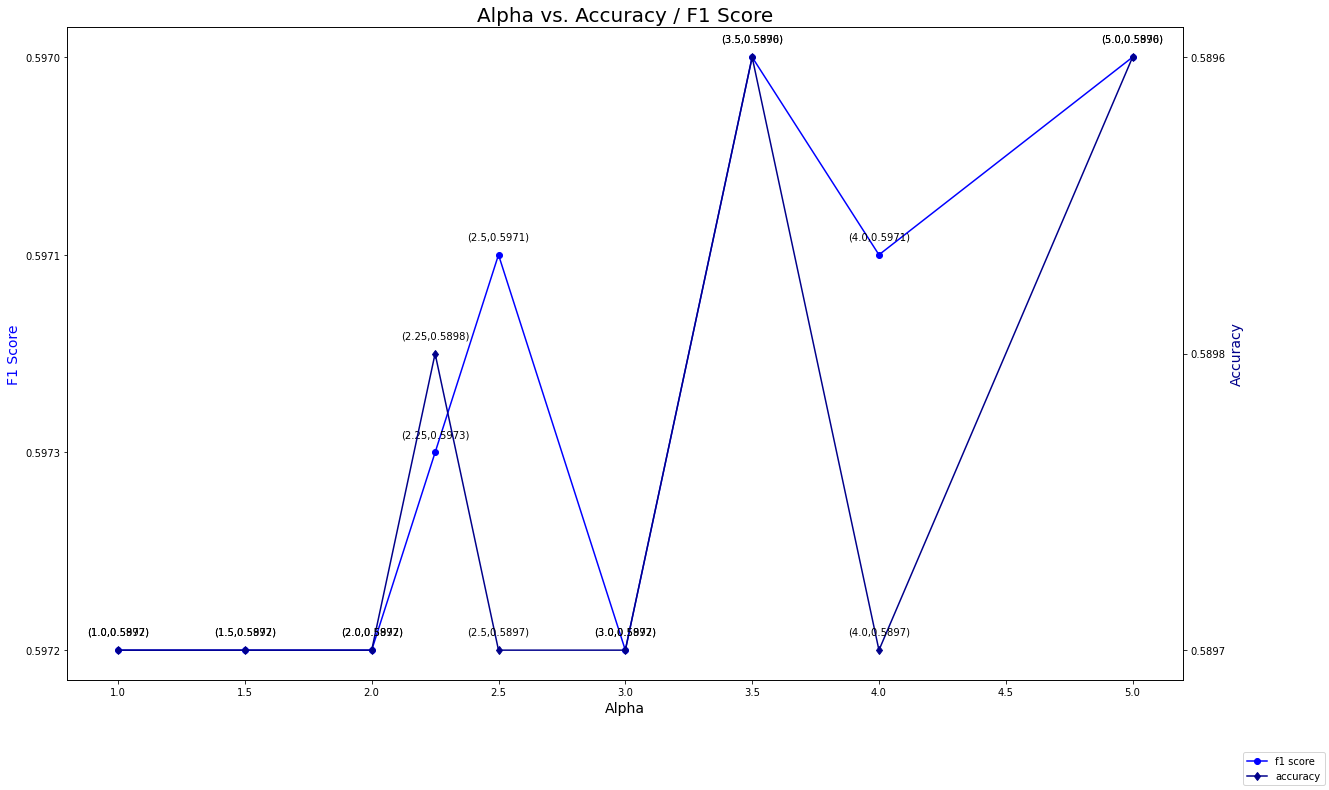

In [25]:
def plot_sub_metrics(ax, df, x_name, y_name, **kwargs):
    ax.plot(df[x_name], df[y_name], **kwargs)
    for x, y in zip(df[x_name], df[y_name]):
        label = f"({x},{y})"
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,15), ha='center')

def plot_metrics(sub_scores_df):
    fig = plt.figure(figsize=(20,12)) 
    ax = fig.subplots()   
    plot_sub_metrics(ax, sub_scores_df, 'alpha', 'f1_score', color='blue', marker='o', label='f1 score')
    ax_twin = ax.twinx()
    plot_sub_metrics(ax_twin, sub_scores_df, 'alpha', 'mean_accuracy', color='darkblue', marker='d', label='accuracy')
    plt.title('Alpha vs. Accuracy / F1 Score', fontsize=20)
    ax.set_xlabel('Alpha', fontsize=14)
    ax.set_ylabel('F1 Score', fontsize=14, color='blue')
    ax_twin.set_ylabel('Accuracy', fontsize=14, color='darkblue')
    fig.legend(loc='lower right')
    plt.show()

plot_metrics(scores_df[(scores_df['alpha'] <= 5) & (scores_df['alpha'] >= 1)])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


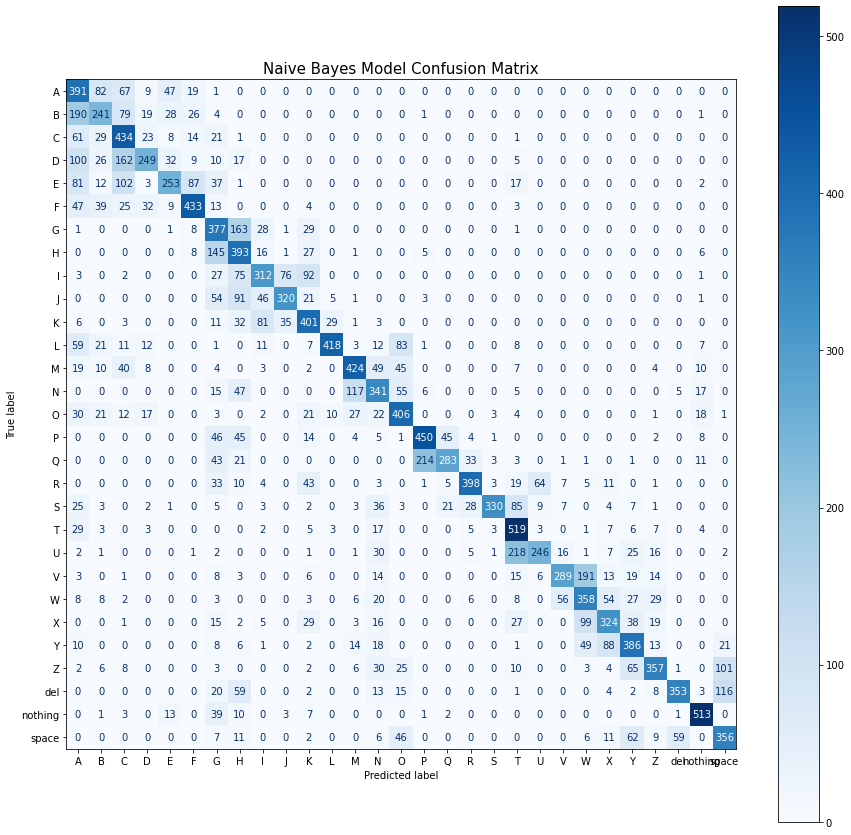

In [26]:
plot_confusion_matrix(X_test_transform, np.ravel(y_test), mnb, model_name='Naive Bayes', col=None)

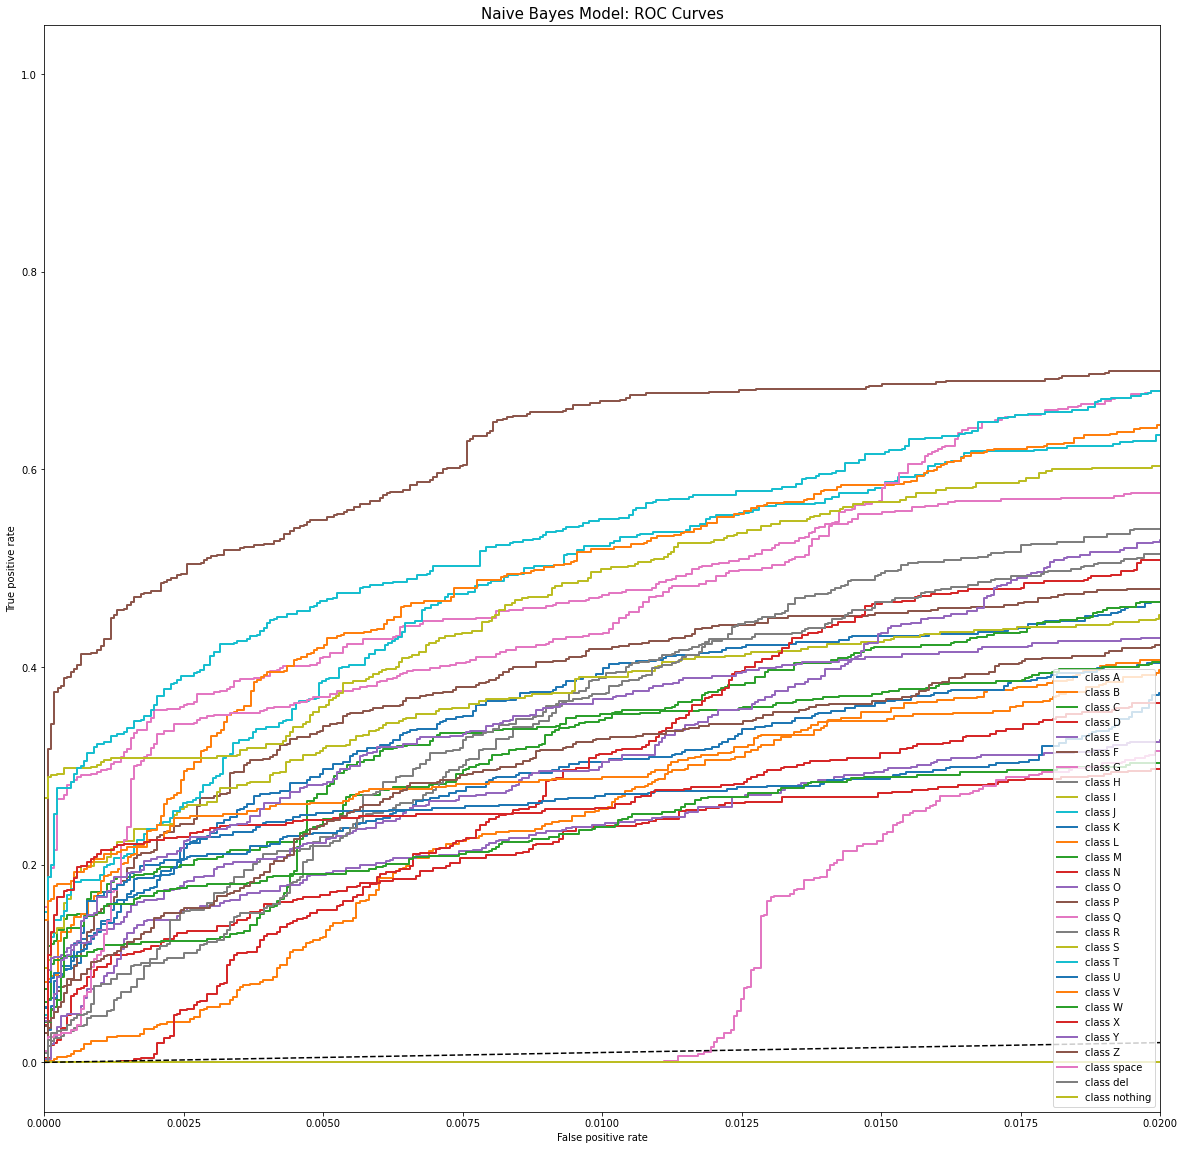

In [27]:
plot_roc_curve( np.ravel(y_test),X_test_transform, mnb, classes=29, model_name='Naive Bayes', string_=True)

<hr>

### 4.2 Logistic Regression

Here we initialize a multiclass logistic regression, fit data, and predict based on test data. A multiclass logisitic regression is an implementation of the logistic regression when predicting more than 2 labels (classes). Unlike the binary logistic regression, it uses cross-entropy loss instead of the loss function and also uses a multinomial probability distribution [8].

*Note: Going forward we'll use the variable train_labels and test_labels which contain integers between 0 and 28.*
*Letter A -> 0, Letter B -> 1, ..., Letter Z -> 25*
*Symbol for "del" -> 26, Symbol for "nothing" -> 27, Symbol for "space" -> 28*

Some notes on the Logistic Regression

The solver parameter should be set to lbfgs. In some older version of SKLEARN not setting the solver to lbfgs has 2 problems - one is that the default 'liblinear' is 40x to 50x slower, and the second is that liblinear doesn't work with multi-class problems. In the latest version of SKLEARN the default is lbfgs.
lbfgs — Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the 2nd derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets (millions of samples). It will be the default solver as of Scikit-learn version 0.22. We chose this for the data set size of ~60K. Works well and produces good accuracy.

**newton-cg** — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the 2nd derivatives. Has a high memory footprint.

**liblinear** — Library for Large Linear Classification. Uses a coordinate descent algorithm, based on minimizing a multivariate function by solving univariate optimization problems in a loop. It moves toward the minimum in one direction at a time. It is the default solver for Scikit-learn versions earlier than 0.22.0. It performs pretty well with high dimensionality; but has several drawbacks. It can get stuck in saddle points, is unable to run in parallel, and can only solve multi-class logistic regression with one-vs.-rest (OVR). Not suitable for what we're trying to do.

**sag** — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Reasonably fast for big datasets.

**saga** — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.

As for penalty leave it at default value of l2. If set to l1 then lbfgs won't work.
solver='lbfgs' sets multi_class='auto'(default) and penatly='l2'(default) is what we used. When solver is set to lbfgs other parameters fall into place.

The call - LogisticRegression(solver='lbfgs') is all that's needed to be set. We can skip specifying the solver parameter if SKLEARN version 0.22 or higher.

Refer to https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406 for detailed description on the solver, penalty, dataset size combination discussion.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


   c_value  f1_score  accuracy_val  precision_val  execution_time
0     0.01  0.887752      0.887759       0.887972       33.384449
1     0.10  0.885872      0.885862       0.886080       34.949528
2     0.50  0.886156      0.886149       0.886363       34.480891
3     0.75  0.886313      0.886322       0.886551       33.651076
4     1.00  0.885898      0.885862       0.886178       33.260951
5     1.50  0.885529      0.885517       0.885701       33.448441
6     2.00  0.886034      0.886034       0.886246       33.496058


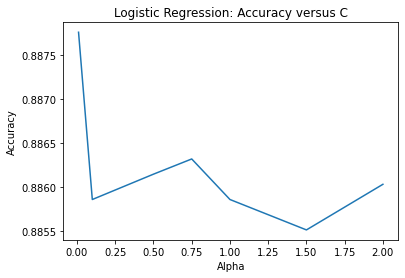

The best C value is 0.01 with an F1 score of 0.8877524393998024
func:logistic_regression_tuning args:[(), {}] took: 237.1412 sec


In [28]:
@timeit
def logistic_regression_tuning():
    # empty lists for storing metrics
    f1 = []
    accuracy = []
    precision = []
    run_time = []
    best_acc = 0
    # c values to iterate through
    c_val = [0.01, 0.1, 0.5, 0.75, 1, 1.5, 2.0]
    # loop through Logistic Regression model C value parameters to find best fit
    for c in c_val:
      start_time = time.time()

      clf_pca = LogisticRegression(C= c, solver='lbfgs') 
      clf_pca.fit(pca_train, train_labels)
      y_pred_pca = clf_pca.predict(pca_test)

      run_time.append(time.time() - start_time)
      # store models metrics for indentifying best c value
      f = metrics.f1_score(test_labels, y_pred_pca, average='weighted')
      acc = metrics.accuracy_score(test_labels, y_pred_pca)
      p = metrics.precision_score(test_labels, y_pred_pca, average='weighted')
      f1.append(f)
      accuracy.append(acc)
      precision.append(p)
    # store metrics in a dataframe
    df = pd.DataFrame(
        { "c_value": c_val,
          "f1_score": f1,
          "accuracy_val": accuracy,
          "precision_val": precision,
          "execution_time": run_time}
    )
    print(df)
    # plot c-value versus accuracy
    plt.title('Logistic Regression: Accuracy versus C')
    plt.plot(df['c_value'], df['accuracy_val'])
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.show()
    
    #return best c-value and print best c-value and f1 score
    best_c_val = df['c_value'][df.f1_score == df.f1_score.max()].iloc[0].item()
    best_f1 = df['f1_score'][df.f1_score == df.f1_score.max()].iloc[0].item()
    print('The best C value is {} with an F1 score of {}'.format(best_c_val, best_f1))
    return best_c_val

c = logistic_regression_tuning()
    

In [29]:
@timeit
def logistic_regression_model():
    #initialize model using best c value identified from previous step
    clf = LogisticRegression(C=c, solver='lbfgs')
    clf.fit(pca_train, train_labels)
    # calculate metrics for best model and store in dictionary
    f1, accuracy, precision, f1_l, precision_l = get_model_metrics(pca_test, test_labels, clf)
    model_results["model_name"].append("LogisticRegression")
    model_results["f1_score"].append(f1)
    model_results["accuracy"].append(accuracy)
    model_results["labels_f1_score"].append(f1_l)
    model_results["labels_precision"].append(precision_l)
    return clf

clf = logistic_regression_model()

******Weighted Metrics********
    F1-score: 0.8878

    Accuracy: 0.8878

    Precision: 0.8880

******Per-label Metrics********
F1 score:
[0.78497202 0.76910017 0.87183811 0.8294702  0.88607595 0.92066116
 0.89372385 0.8998358  0.90436242 0.89236431 0.92424242 0.93528505
 0.88636364 0.90401969 0.87848933 0.94354839 0.95819936 0.93443983
 0.93252595 0.91400491 0.87393526 0.86546701 0.82465278 0.8024369
 0.84491115 0.92788462 0.89490969 0.99578059 0.83831283]
Precision:
[0.77322835 0.76910017 0.87037037 0.83779264 0.88983051 0.92066116
 0.9112628  0.88961039 0.89238411 0.88990826 0.93686007 0.94254658
 0.89950577 0.90180033 0.86290323 0.95121951 0.94603175 0.94147157
 0.92771084 0.92384106 0.85642738 0.86324786 0.84219858 0.80735552
 0.84219002 0.9264     0.87620579 0.99662162 0.84724689]
func:logistic_regression_model args:[(), {}] took: 33.9093 sec


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


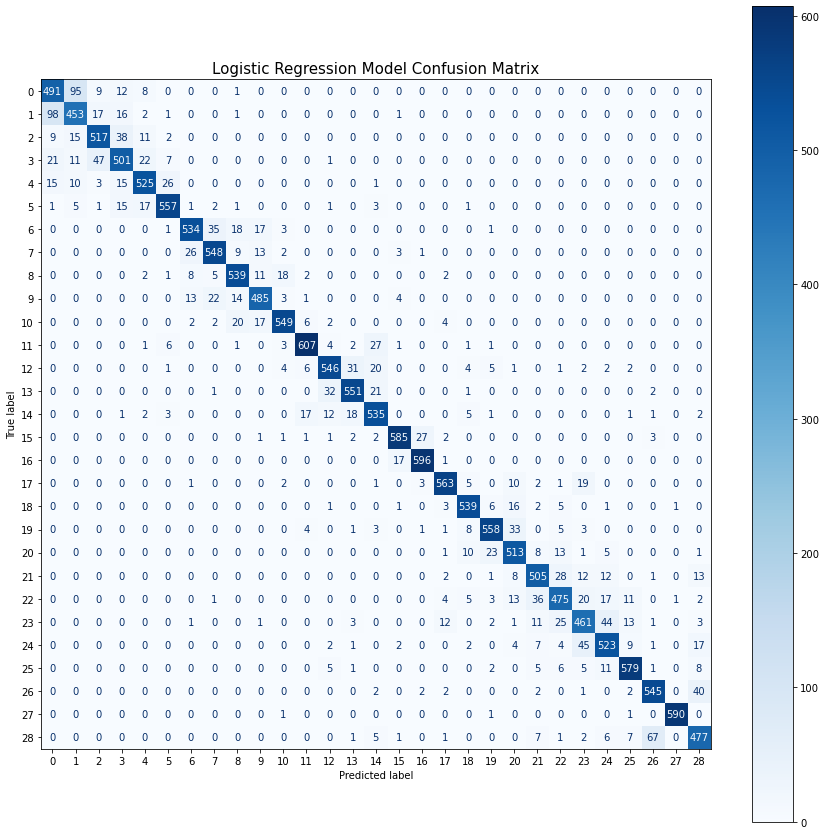

In [30]:
plot_confusion_matrix(pca_test, test_labels, clf, model_name='Logistic Regression', col=None)

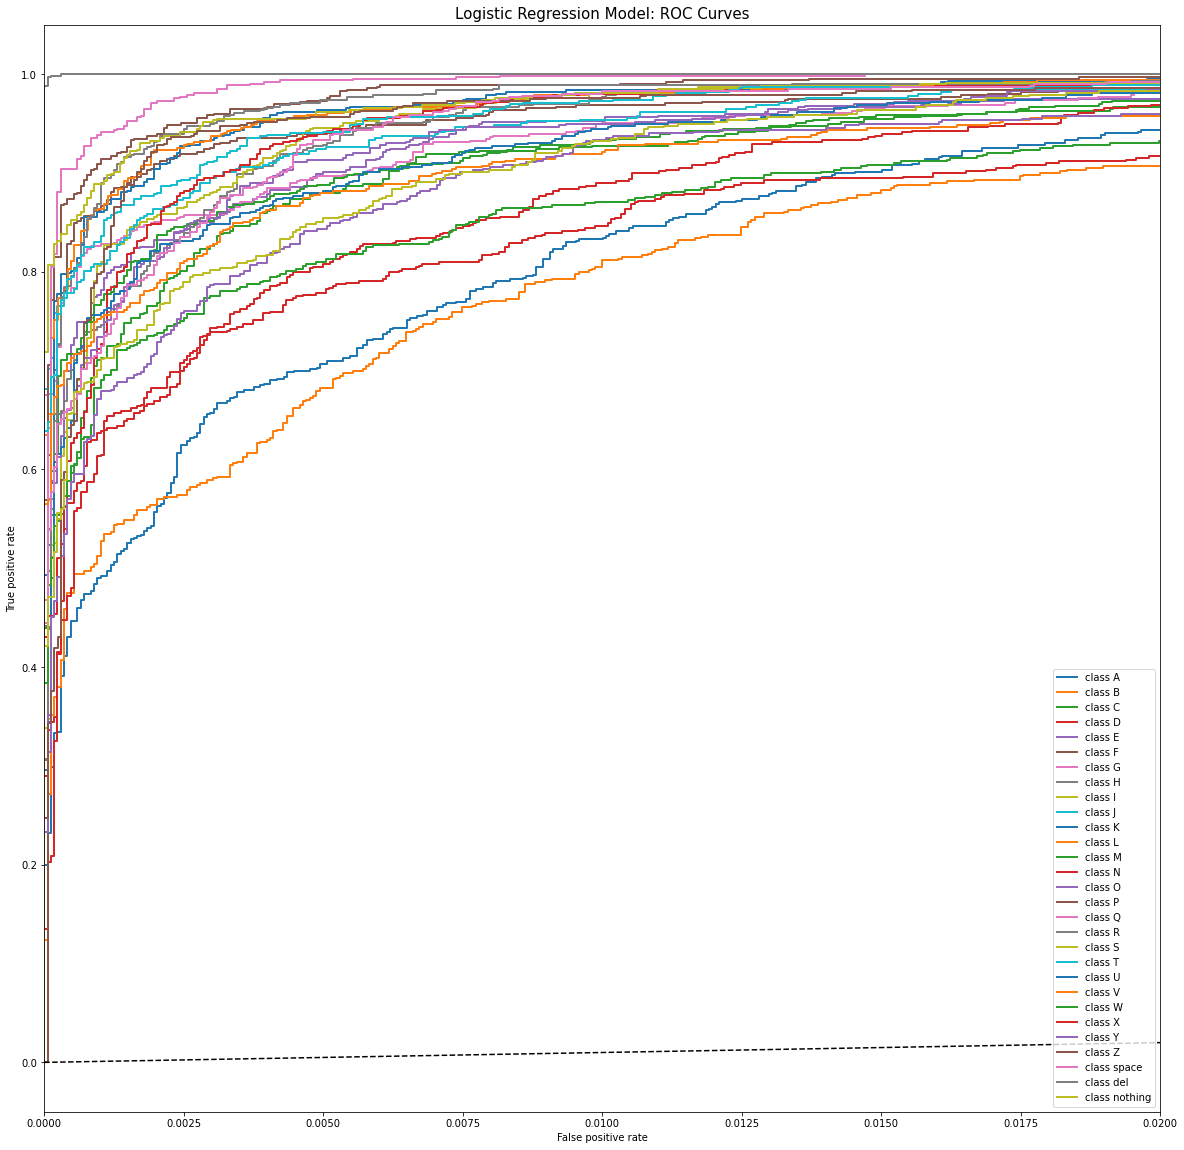

In [31]:
plot_roc_curve(test_labels,pca_test, clf, classes=29, model_name='Logistic Regression')

<hr>

### 4.3 XGBoost

>XGBoost is a supervised learning algorithm that uses gradient boosted trees. The model essentially works by combining an ensemble of predictions from weaker models. One of the key benefits of this model is outperforms most simple models and it is parallelizable so that it works well with large datasets.
 
For XGBoost we are tuning the max_depth, learning_rate, gamma, and alpha parameters [4]. 
 
1.	The max_depth is the maximum depth of the tree.  The larger the max_depth the more complex the model and this increases the chances of overfitting. 
2.	The learning_rate helps to control the weight of new trees being added.
3.	The gamma is the minimum loss reduction required to make another split on the tree. The larger the value the less complex the model will be.
4.	Alpha is L1 Regularization Lasso Regression which works well for reducing the number of features in the dataset as well as preventing overfitting with a higher alpha value.


In [32]:
@timeit
def tune_xgboost():
    # empty dictionary to store results
    results = {}
    best_params = []
    # parameters to iterate through using grid search cv
    params = [
        {'max_depth': range (4, 10, 2)},
        {'learning_rate': [0.01, 0.1, 0.2]},
        {'gamma': [0.1, 0.2]},
        {'alpha': [0.1, 0.2, 0.3]}]

    # list of names of parameters for looping purposes
    param_names = ['max_depth', 'learning_rate','gamma', 'alpha']
    
    #intialize xgboost model
    xgb_2 = xgb.XGBClassifier(objective= 'multi:softmax', tree_method='hist', eval_metric='mlogloss',early_stopping_rounds=10, nthread=4,seed=18)
    for i in range(len(params)): 
    # initalize gridsearch cv to search identify optimal parameters of predefined XGBoost algorithm using 2 folds
        clf = GridSearchCV(estimator=xgb_2, param_grid=params[i], n_jobs = -1, cv = 2,verbose=True)
        # fit XGBoost model to parameters specified above
        clf.fit(pca_train[:15000],train_labels[:15000])
        # store results of every parameter run
        results_df = pd.DataFrame({param_names[i]: params[i][param_names[i]], 'accuracy': clf.cv_results_['mean_test_score']})
        # create dataframe of all results to find best parameter results
        all_results = pd.DataFrame(clf.cv_results_)
        # get column with parameter values
        param_col = [col for col in all_results if col.startswith('param_')]
        # print out the parameters that were part of the experiment
        print('\n Running XGBoost experiments using: {}'.format(params[i]))
        best_param = all_results[param_col][all_results['rank_test_score'] == 1].iloc[0].item()
        best_params.append(best_param)
        print("The best parameter value for {} is {}.".format(param_names[i],best_param))
        print("The best score is", clf.best_score_,"\n")
        results[param_names[i]] = results_df

    return results, best_params

results, best_params = tune_xgboost()

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:54:51] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


/n Running XGBoost experiments using: {'max_depth': range(4, 10, 2)}
The best parameter value for max_depth is 4.
The best score is 0.8313333333333333 

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:03] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:00] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:50:48] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:14:03] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:00] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


/n Running XGBoost experiments using: {'learning_rate': [0.01, 0.1, 0.2]}
The best parameter value for learning_rate is 0.2.
The best score is 0.8366 

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:08] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


/n Running XGBoost experiments using: {'gamma': [0.1, 0.2]}
The best parameter value for gamma is 0.1.
The best score is 0.8159333333333333 

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:04:03] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


/n Running XGBoost experiments using: {'alpha': [0.1, 0.2, 0.3]}
The best parameter value for alpha is 0.1.
The best score is 0.8266666666666667 

func:tune_xgboost args:[(), {}] took: 10296.6407 sec


Next we are producing scatterplots of the average accuracies for the various parameters that we test above.

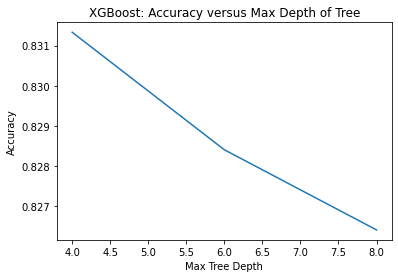

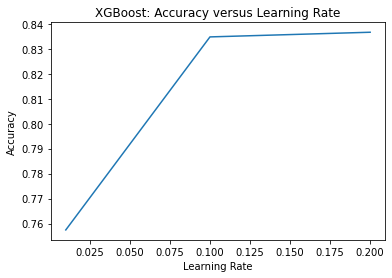

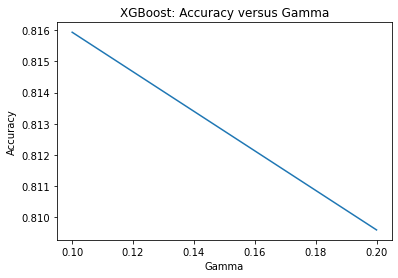

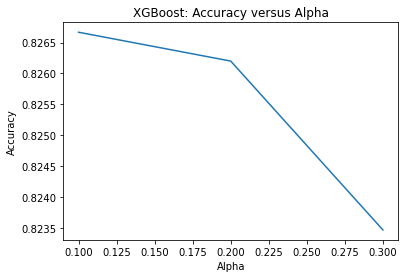

func:plot_xgboost_params args:[(), {}] took: 0.6536 sec


In [33]:
@timeit
def plot_xgboost_params():
    # plot max depth versus accuracy
    plt.title('XGBoost: Accuracy versus Max Depth of Tree')
    plt.plot(results['max_depth']['max_depth'], results['max_depth']['accuracy'])
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Accuracy')
    plt.show()
    
    # plot learning rate versus accuracy
    plt.title('XGBoost: Accuracy versus Learning Rate')
    plt.plot(results['learning_rate']['learning_rate'], results['learning_rate']['accuracy'])
    plt.xlabel('Learning Rate')
    plt.ylabel('Accuracy')
    plt.show()

    # plot gamma versus accuracy
    plt.title('XGBoost: Accuracy versus Gamma')
    plt.plot(results['gamma']['gamma'], results['gamma']['accuracy'])
    plt.xlabel('Gamma')
    plt.ylabel('Accuracy')
    plt.show()

    # plot alpha versus accuracy
    plt.title('XGBoost: Accuracy versus Alpha')
    plt.plot(results['alpha']['alpha'], results['alpha']['accuracy'])
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.show()

plot_xgboost_params()

Now we are producing a new XGBoost model with the best parameters identified from the previous step. The metrics values will be stored for comparison to other models in the final section. 

In [34]:
@timeit
def best_xgb_model():
    # intialize xgboost using best parameters identified from previous step
    xgb1 = xgb.XGBClassifier(objective= 'multi:softmax', 
                              tree_method='hist', 
                              eval_metric='mlogloss', 
                              max_depth = best_params[0],
                              learning_rate = best_params[1],
                              gamma = best_params[2],
                              alpha = best_params[3],nthread=4,seed=18)
    # fit model
    xgb1.fit(pca_train, train_labels)
    f1, accuracy, precision, f1_l, precision_l = get_model_metrics(pca_test, test_labels, xgb1)
    model_results["model_name"].append("XGboost")
    model_results["f1_score"].append(f1)
    model_results["accuracy"].append(accuracy)
    model_results["labels_f1_score"].append(f1_l)
    model_results["labels_precision"].append(precision_l)
    return xgb1
xgb1 = best_xgb_model()

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

[20:14:04] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:00] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:52:41] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


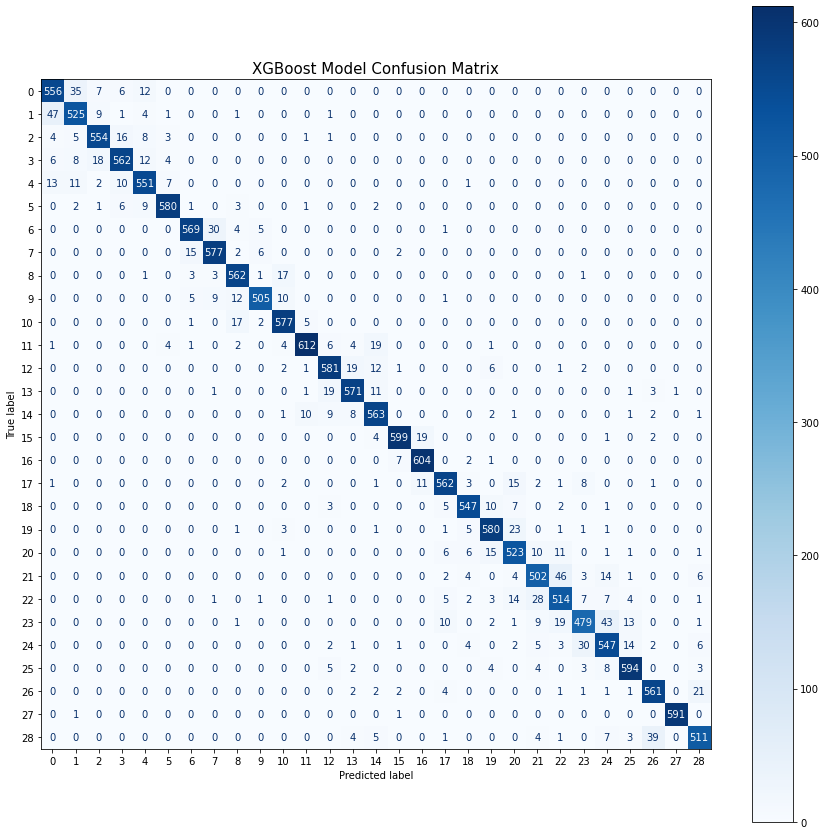

In [35]:
plot_confusion_matrix(pca_test, test_labels, xgb1, model_name='XGBoost', col=None)

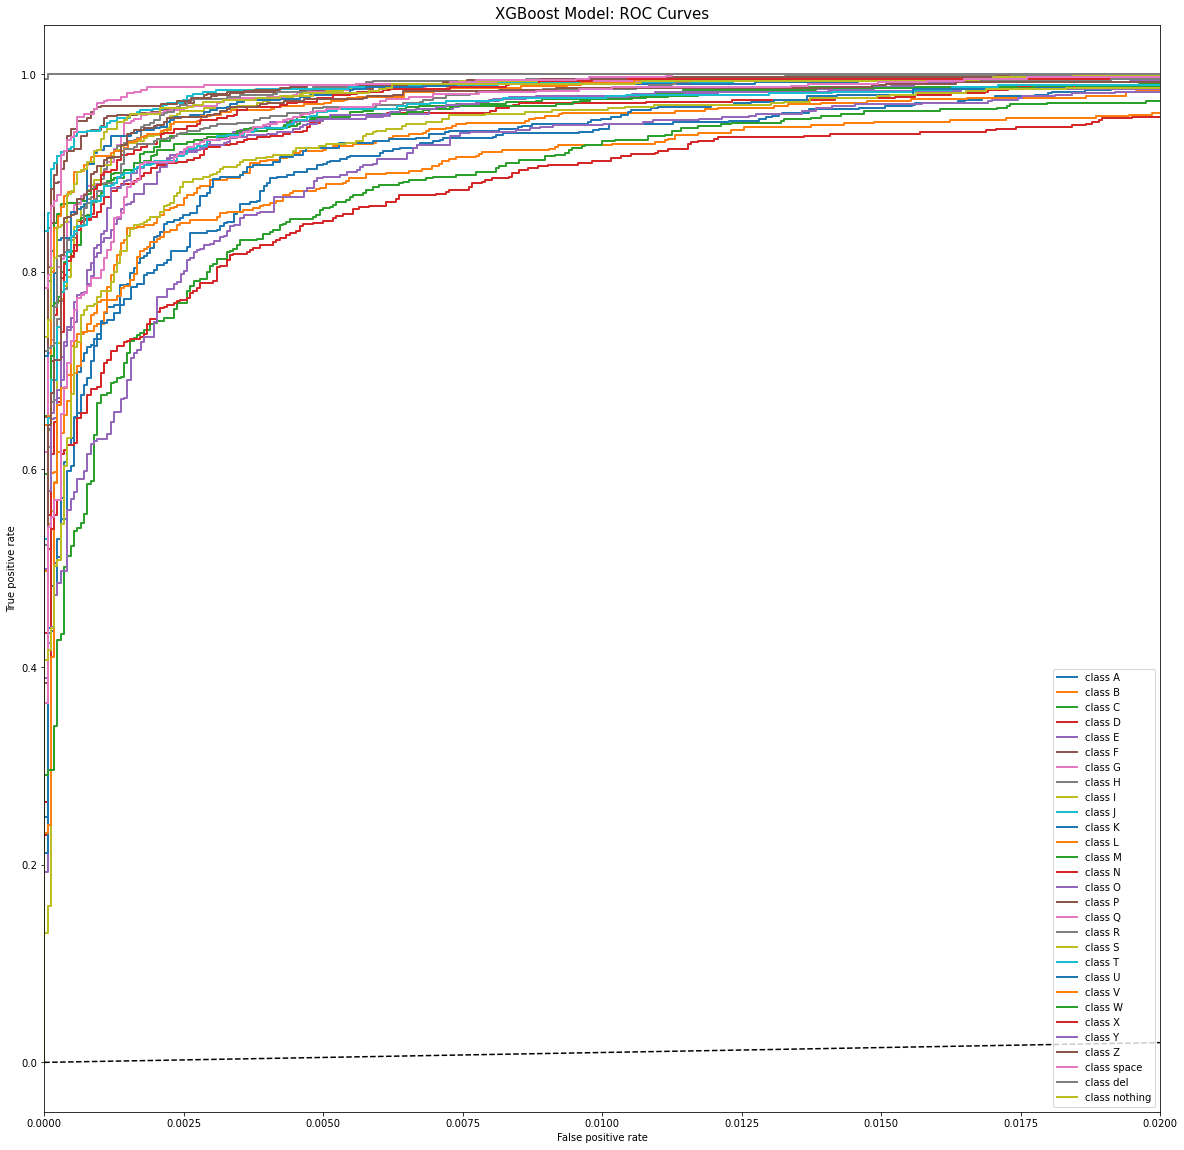

In [36]:
plot_roc_curve(test_labels,pca_test, xgb1, classes=29, model_name='XGBoost')

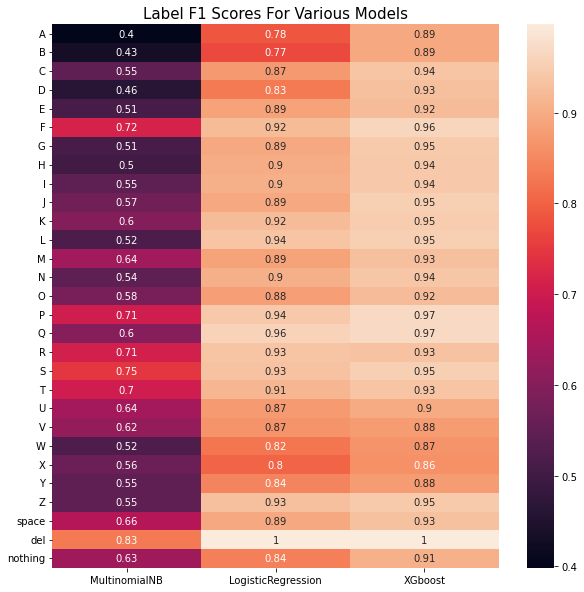

In [37]:
create_final_summary_table()

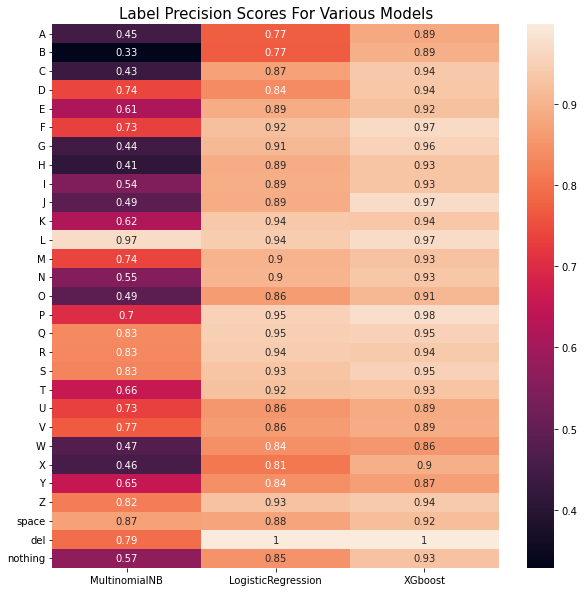

In [38]:
create_final_summary_table(labels= all_labels, num_labels=29, metric = 'labels_precision', title = 'Label Precision Scores For Various Models')

In [39]:
# export model results
pd.DataFrame(model_results).to_csv('model_results.csv', index=None)

In [40]:
# Clear memory
del clf, xgb1

In [41]:
# read back in from previous section because of memory limitations
#model_results = pd.read_csv('model_results.csv').to_dict()

<hr>

### 4.4 Convolutional Neural Networks

A CNN is a deep learning algorithm which can take a set of features (as in our case it is set of pixels of the image) as input and transform them through a series of hidden layers. Each hidden layer is made up of a set of neurons, where each neuron is fully connected to all neurons in the previous layer, and where neurons in a single layer function completely independently and do not share any connections. Typically these layers are of 3 main types: (1) Convolutional, (2) Pooling and (3) Fully-connected layers. The last fully-connected layer is called the “output layer” and in classification settings it represents the class scores. The pre-processing required in a CNN is much lower as compared to other classification algorithms shown above. While with the above methods, filters are hand-engineered, with enough training, CNN on the other hand has the ability to learn these filters/characteristics inherently.

To train our above dataset, we leveraged Keras and TesnorFlow libararies. While TensorFlow is the open-source library for a various number of tasks in machine learning. Keras serves as a high-level API built on top of TensorFlow specializing particularly in deep learning. With keras it is relatively easy to create a complicated neural network from the scratch with just a few lines of code. Typically a deep neural networks created from scratch takes a lot of data and time to train before it could be deployed in for production. So, keras provide a catalogue of pretrained models to choose from to serve as a baseline model. And as application developers, we can add training layers on top of these baseline model to learn any application specific or data specific characteristics. We tried several pretrained models like (1) VGG, (2) Xception, (3) InceptionVResNetV2, and (4) InceptionV3 to name a few to train our ASL dataset. In the interest of time and space, we have presented only the output of the VGG model in this presentation.

We created the following layers in our network:

1. Baseline Model - We have used the VGG model as the baseline.
2. Flatten Layer - This layer flattens the output.
3. Dense layer with a 'relu' activation - This layer basically does a dot product of the input with a kernel and then adds the bias to that product.  Finally the result is passed through a 'relu' activation.
4. Dropout layer - The Dropout layer randomly sets the input units to 0 with a frequency of rate at each step during training time.
5. Dense layer with a 'softmax' activation - This layer is same as the step 3 but with 'softmax' as activation function instead of a 'relu' function.

In [43]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

train_dir = '/home/jupyter/images/asl_alphabet_train/asl_alphabet_train/'
test_dir = '/home/jupyter/images/asl_alphabet_test/asl_alphabet_test/'

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    # random state = 18 to match data above
    #Shuffle the dataset
    images,labels = shuffle(images,labels,random_state=18)
    # Split data to match train test split from above using random_state=18
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels,random_state=18, test_size = 0.20)
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    #Loading in model results from other models have to run on new gcp instance due to GCP memory limitations
    # model_results = pd.read_csv('model_results.csv')
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : D | L | Z | Q | U | R | O | nothing | C | B | X | S | K | V | F | space | E | J | P | del | A | G | Y | H | I | N | W | M | T | 
Loaded 69600 images for training, Train data shape = (69600, 64, 64, 3)
Loaded 17400 images for testing Test data shape = (17400, 64, 64, 3)


In [44]:
# Init the VGG model 
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)


2021-12-01 23:11:37.185629: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-12-01 23:11:37.187989: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a7feeea2e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-01 23:11:37.188030: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-01 23:11:37.191501: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f357775fdd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3577880410> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35776da7d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f357851cfd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f357836cad0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35778d1ed0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f357777c0d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35779e5090> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35779e2d10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3577b9ecd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3577ba4f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [45]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(29, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                29725     
Total params: 16,842,589
Trainable params: 2,127,901
Non-trainable params: 14,714,688
_________________________________________________________________


In [46]:
# Load the normalized images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 10

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=train_batchsize,
        class_mode='categorical')

# Data generator for validation data
validation_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 87000 images belonging to 29 classes.
Found 0 images belonging to 0 classes.


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                29725     
Total params: 16,842,589
Trainable params: 2,127,901
Non-trainable params: 14,714,688
_________________________________________________________________


In [48]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [49]:
model_hist = model.fit(X_train, Y_train, batch_size = 64, epochs = 5, validation_split = 0.1)

Train on 62640 samples, validate on 6960 samples
Epoch 1/5
62640/62640 [==============================] - 807s 13ms/sample - loss: 1.4338 - acc: 0.6392 - val_loss: 0.6038 - val_acc: 0.8861
Epoch 2/5
62640/62640 [==============================] - 797s 13ms/sample - loss: 0.4829 - acc: 0.8843 - val_loss: 0.2852 - val_acc: 0.9476
Epoch 3/5
62640/62640 [==============================] - 790s 13ms/sample - loss: 0.2652 - acc: 0.9391 - val_loss: 0.1637 - val_acc: 0.9713
Epoch 4/5
62640/62640 [==============================] - 792s 13ms/sample - loss: 0.1711 - acc: 0.9610 - val_loss: 0.1085 - val_acc: 0.9803
Epoch 5/5
62640/62640 [==============================] - 803s 13ms/sample - loss: 0.1193 - acc: 0.9724 - val_loss: 0.0753 - val_acc: 0.9865


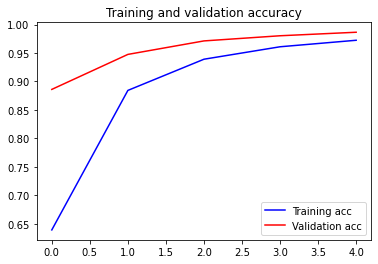

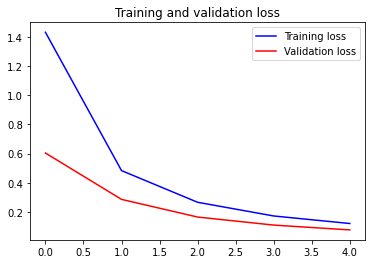

In [50]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(model_hist)

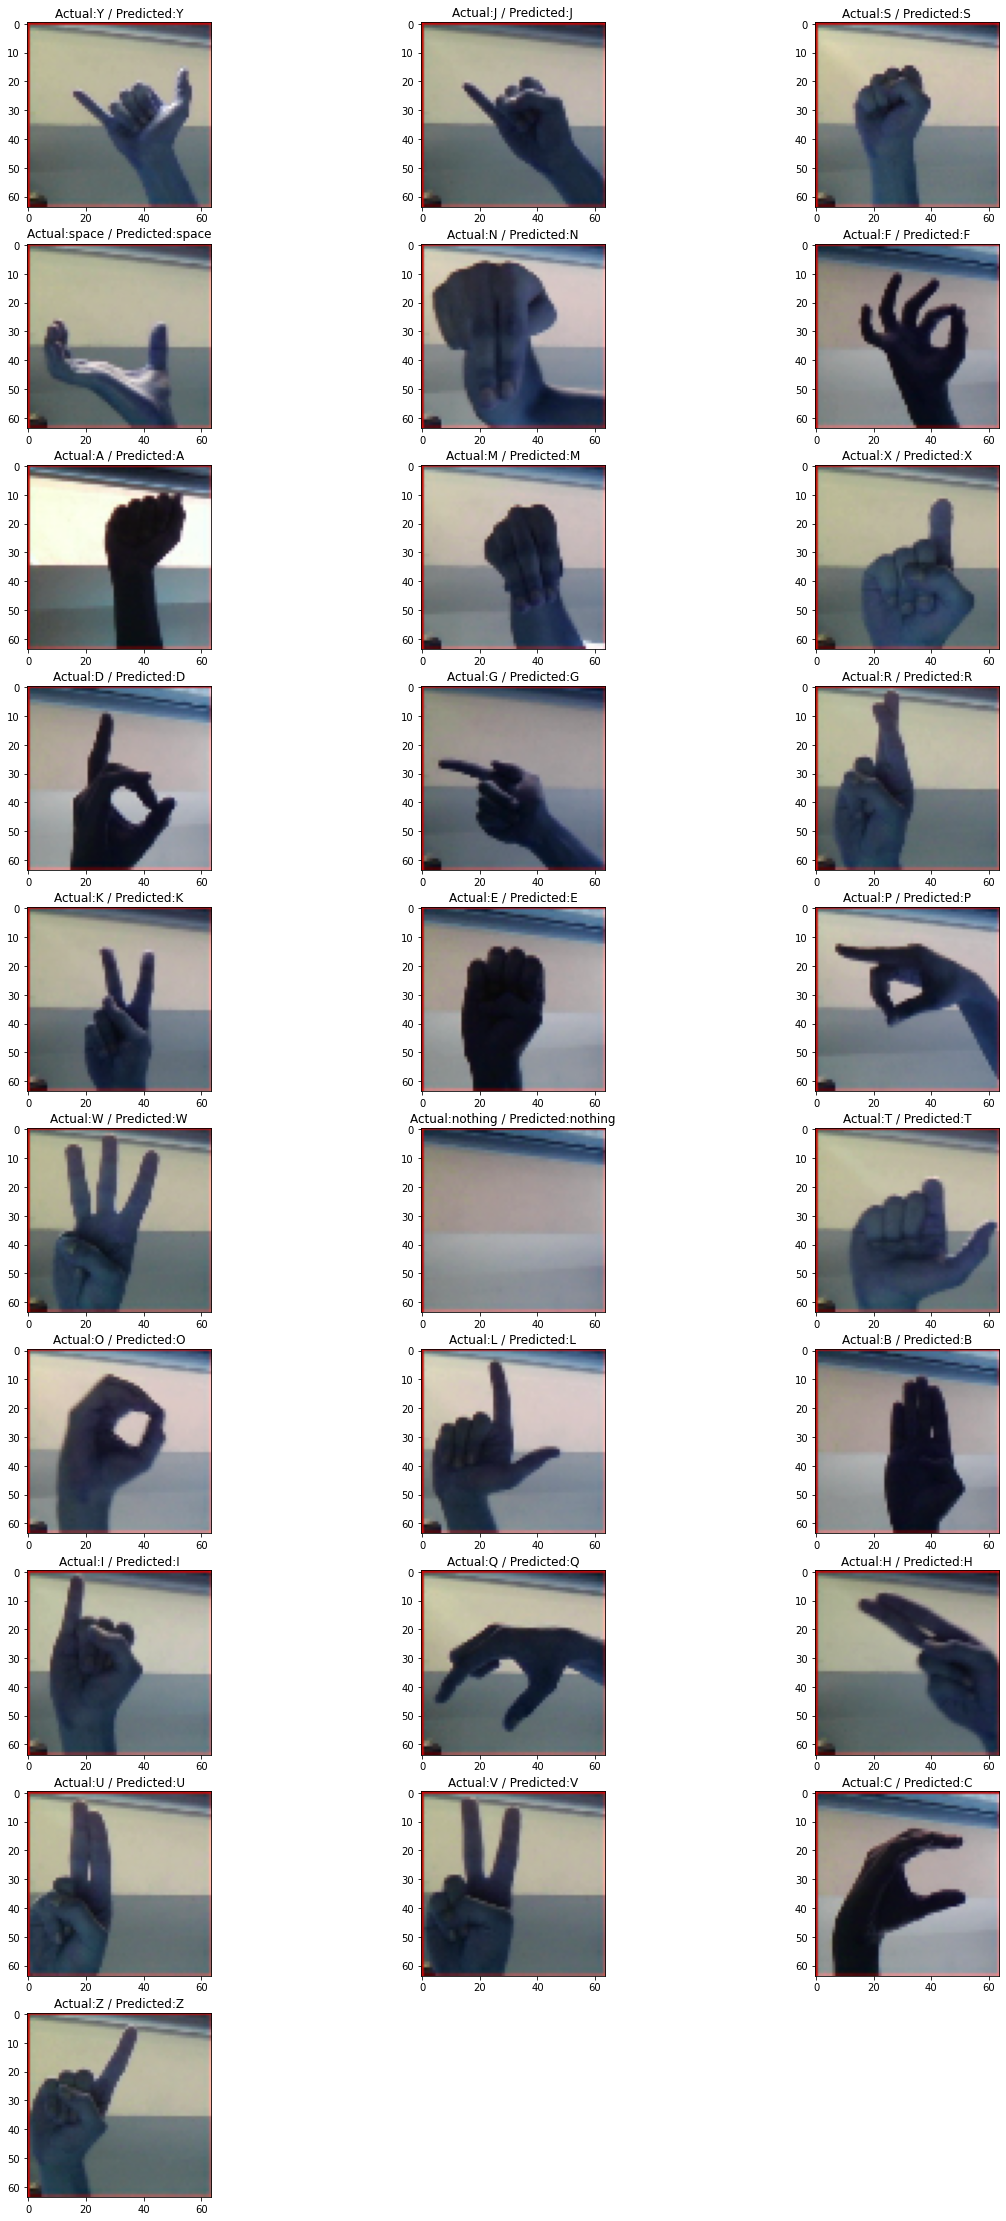

In [51]:
from PIL import Image

labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

inv_labels_dict = {v: k for k, v in labels_dict.items()}

size_img = 64,64            
plt.figure(figsize=(20,40))
for i in enumerate(os.listdir(test_dir)):
    image = cv2.imread(test_dir+'/'+i[1])
    image = np.asarray(image)
    image = image/255
    image = cv2.resize(image, size_img)
    
    plt.subplot(10,3,i[0]+1)
    plt.imshow(image)
    pred = np.argmax(model.predict(image.reshape(-1,64,64,3)))
    #print(pred, i[1])
    prediction = -1
    for j in range(29):
        if inv_labels_dict[pred] == inv_labels_dict[j]:
            prediction=inv_labels_dict[pred]
        else:
            continue       
    plt.title('Actual:{0} / Predicted:{1}'.format(i[1].split('_')[0],prediction))
    
plt.show()    

In [52]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

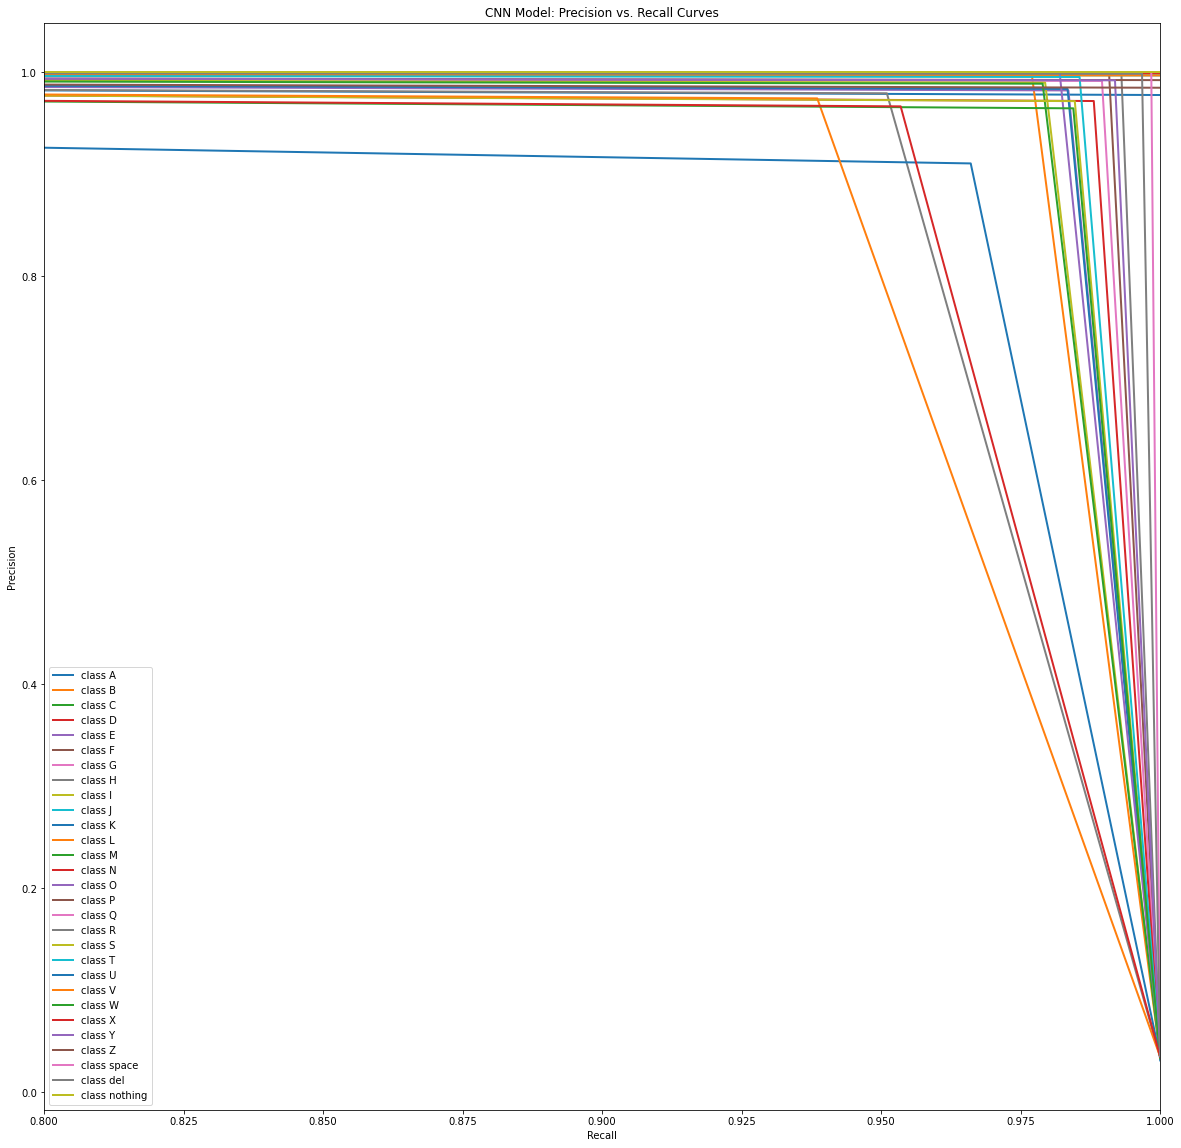

In [53]:
from sklearn.metrics import precision_recall_curve, roc_curve
def cnn_precision_recall_curve():
    precision = dict()
    recall = dict()
    plt.figure(figsize=(20, 20))
    for clsi in range(29):
        precision[clsi], recall[clsi], _ = precision_recall_curve(Y_test[:,clsi], yhat_classes == clsi)
        plt.plot(recall[clsi], precision[clsi], lw=2, label='class {}'.format(inv_labels_dict[clsi]))

    plt.xlim(0.8, 1.0) 
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("CNN Model: Precision vs. Recall Curves")
    plt.show()
cnn_precision_recall_curve()

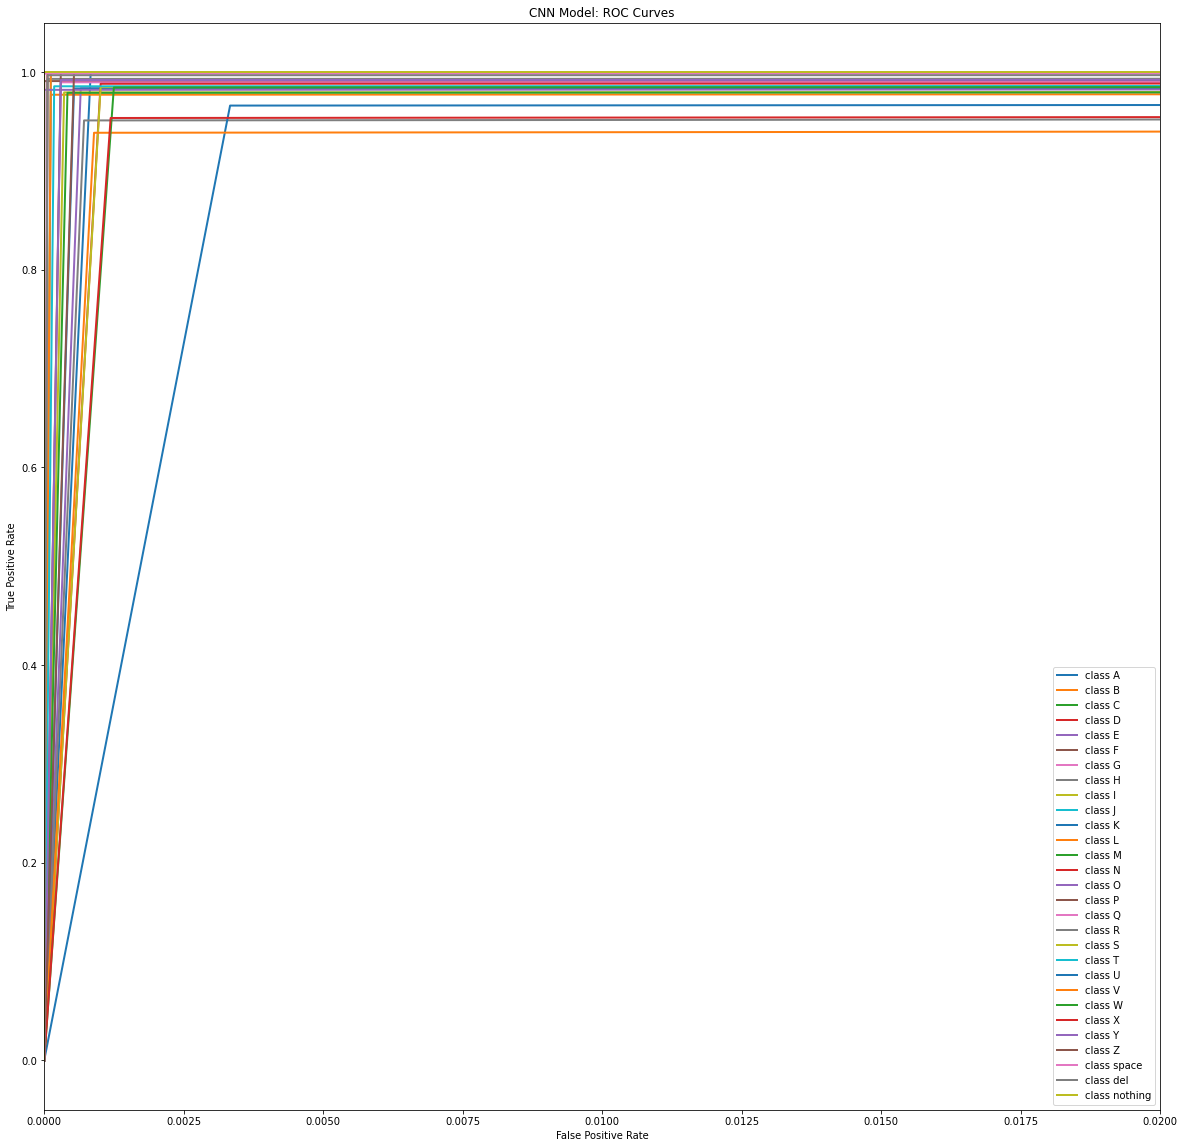

In [54]:
def cnn_roc_curve():
    fpr = dict()
    tpr = dict()
    plt.figure(figsize=(20,20))
    for clsi in range(29):
        fpr[clsi], tpr[clsi], _ = roc_curve(Y_test[:,clsi], yhat_classes == clsi)
        plt.plot(fpr[clsi], tpr[clsi], lw=2, label='class {}'.format(inv_labels_dict[clsi]))
    plt.xlim(0.0, 0.02)  
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.title("CNN Model: ROC Curves")
    plt.show()
cnn_roc_curve()

In [55]:
def get_cnn_metrics():
    
    accuracy = []
    f1_l = []
    precision_l = []
    for clsi in range(29):
        # accuracy: (tp + tn) / (p + n)
        accuracy.append(accuracy_score(Y_test[:,clsi], yhat_classes == clsi))
        # f1: 2 tp / (2 tp + fp + fn)
        f1_l.append(f1_score(Y_test[:,clsi], yhat_classes == clsi, average='weighted'))
        precision_l.append(precision_score(Y_test[:,clsi], yhat_classes == clsi, average='weighted'))
        print('Label: %s' % inv_labels_dict[clsi],'Accuracy: %f' % accuracy[clsi], 'F1 score: %f' % f1_l[clsi])
    accuracy = np.mean(accuracy)
    f1 = np.mean(f1_l)
    precision = np.mean(precision_l)
    
        # Print out scores
    print("\n******Weighted Metrics********")
    print('    F1-score: {:.4f}\n'.format(f1))
    print('    Accuracy: {:.4f}\n'.format(accuracy))
    print('    Precision: {:.4f}'.format(precision))
    
        # Print out scores
    print("\n******Per-label Metrics********")
    print("F1 score:")
    print(f1_l)
    print("Precision:")
    print(precision_l)
    
    model_results["model_name"].append("CNN")
    model_results["f1_score"].append(f1)
    model_results["accuracy"].append(accuracy)
    model_results["labels_f1_score"].append(f1_l)
    model_results["labels_precision"].append(precision_l)
    
    # model_results["model_name"][3] = "CNN"
    # model_results["f1_score"][3] = f1
    # model_results["accuracy"][3] = accuracy
    # model_results["labels_f1_score"][3] = f1_l
    # model_results["labels_precision"][3] = precision_l
    
    return f1, accuracy, precision, f1_l, precision_l 
    
    
f1, accuracy, precision, f1_l, precision_l = get_cnn_metrics()

Label: A Accuracy: 0.999195 F1 score: 0.999200
Label: B Accuracy: 0.999080 F1 score: 0.999076
Label: C Accuracy: 1.000000 F1 score: 1.000000
Label: D Accuracy: 0.999943 F1 score: 0.999943
Label: E Accuracy: 0.998793 F1 score: 0.998794
Label: F Accuracy: 0.999655 F1 score: 0.999654
Label: G Accuracy: 0.999368 F1 score: 0.999368
Label: H Accuracy: 0.999713 F1 score: 0.999712
Label: I Accuracy: 0.998966 F1 score: 0.998963
Label: J Accuracy: 0.999885 F1 score: 0.999885
Label: K Accuracy: 0.998966 F1 score: 0.998966
Label: L Accuracy: 0.999885 F1 score: 0.999885
Label: M Accuracy: 0.998851 F1 score: 0.998848
Label: N Accuracy: 0.998621 F1 score: 0.998626
Label: O Accuracy: 0.999368 F1 score: 0.999365
Label: P Accuracy: 0.999713 F1 score: 0.999713
Label: Q Accuracy: 1.000000 F1 score: 1.000000
Label: R Accuracy: 0.997644 F1 score: 0.997627
Label: S Accuracy: 0.998506 F1 score: 0.998511
Label: T Accuracy: 0.999310 F1 score: 0.999309
Label: U Accuracy: 0.995632 F1 score: 0.995695
Label: V Accu

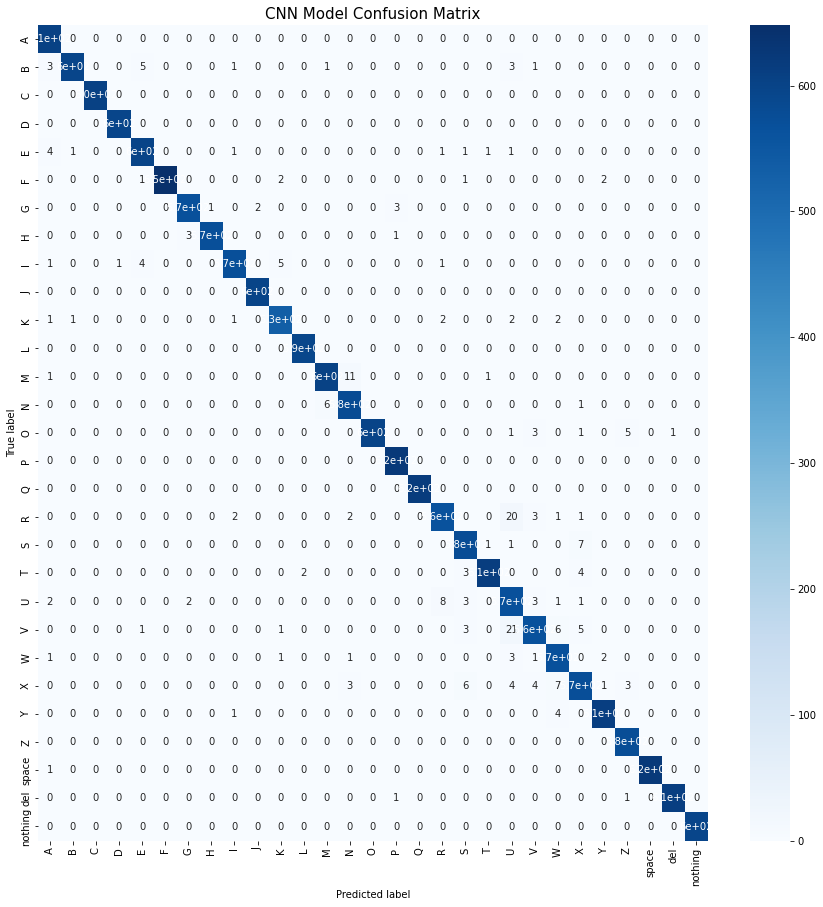

In [57]:
def cnn_confusion_matrix():
    cm = confusion_matrix(np.argmax(Y_test, axis=1), yhat_classes)
    labels = [inv_labels_dict[i] for i in range(29)]

    cm_df = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)

    plt.figure(figsize=(15,15))
    sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
    plt.title('CNN Model Confusion Matrix', size = 15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cnn_confusion_matrix()

# 5. Conclusion

### 5.1 Key Results
As expected the Convolutional Neural Network (CNN) outperformed all other models across all 29 classes (at approximately a .999 F1 score for each label) . See _"Label F1 Scores for Various Models"_ and _"Label Precision Scores For Various Models"_ tables below. 

_Note: the tables are rounded to two decimal places._

The key results are as follows:

1. CNN was the best performing model with an overall accuracy of  __0.9990__, precision of __0.9991__, and F1 Score of __0.9990__. It had higher F1 Scores and Precision scores across all labels.

2. XGBoost had the second best model performance with accuracy of __0.9287__, precision of __0.9289__, and F1 Score of __0.9286__. This model similar to the Logistic Regression and Naive Bayes had trouble distinguishing between the sign for "A" and the sign for "B".

3. The Logistic Regression performed extremely well despite the short amount of training time compared to the CNN and XGBoost models. This is likely due to the fact we are working with a highly sparse dataset with a large number of features as compared to rows. The model had an overall accuracy of __0.8878__, precision of __0.8880__, and F1 Score of __0.8878__.
4. The Naive Bayes model, our baseline model, was the worst performing model of the four with overall accuracy of __0.5872__, precision of __0.6413__, and F1 Score of __0.5899__. We were able to improve the original accuracy of the model from 20% to around 58% using the pre-processing steps of applying a Gaussian blur, Canny edge detection, and dimensionality reduction through PCA.




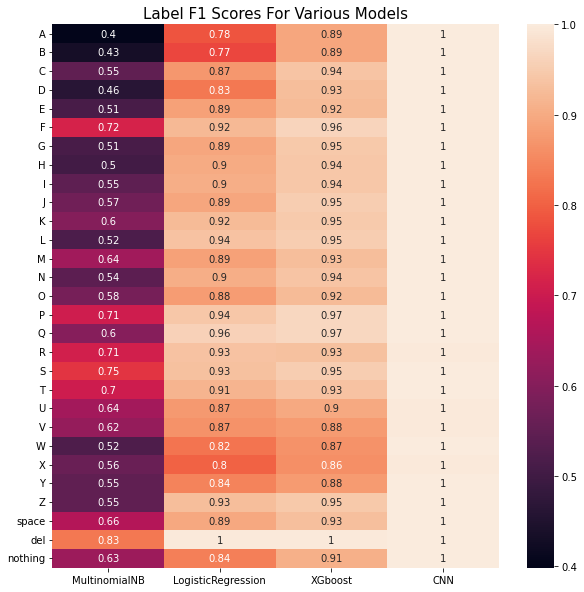

In [58]:
create_final_summary_table()

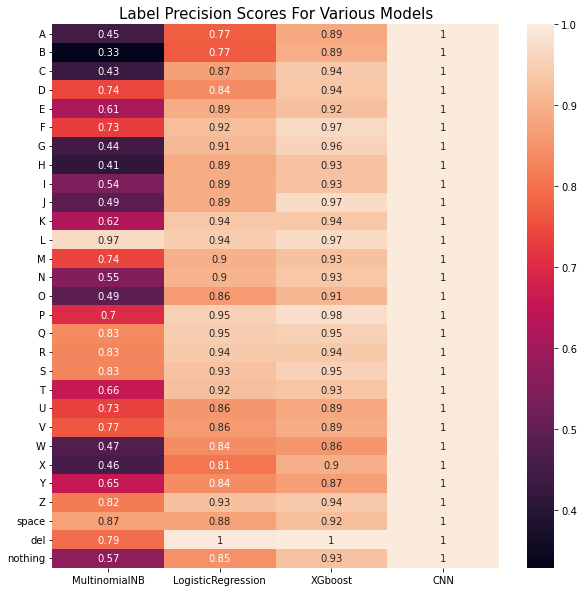

In [59]:
create_final_summary_table(labels= all_labels, num_labels=29, metric = 'labels_precision', title = 'Label Precision Scores For Various Models')

### 5.2 Lessons Learned
- __Tradeoff between Speed and Accuracy__: Throughout the process, we observed that often times the higher performing models such as CNN and XGBoost required more training time (1-3 hours) to achieve high levels of accuracy, whereas the less computationally expensive models Naive Bayes and Logistic Regression were able to achieve reasonable levels of accuracy in a matter of minutes.
- __Overall CNN Performance__: while it takes lot of time to train CNN there is absolute very little time we spend in preprocessing the data. As we saw in section 4.4 above we fed the data straight away in to the network and the network learns all the data specific intricacies and adapts the model accordingly.
- __Keras simplicity__: We all have implemented neural networks from the scratch one way or the other in our previous projects. The implementation details of the data plumbing including the handling of the matrices and vectors, the choice of activation functions and their implemention, calculation of derivatives and the implementation of the back prorpogation for even a simple network can be daunting. With keras, it is as simple as identifying the size of the convolutional, pooling and fully-connected layers. Those above gory implementation details were left for keras to handle.
-__placholder__:
-__placholder__:

### 5.3 Future Work
The CNN and XGBoost models classify the 87,000 ASL images. However, we do have concerns with the generalizability of the model that if the model was introduced to images outside of the training and test data provided on Akash Nagaraj’s Kaggle repository. Specifically, it is likely our model would not perform well with images that have a lot of background noise and include more than the image of a hand. 

_Note: All the training and test images in the repository have the hand that is signing relatively centered with the same background._

Therefore, for future work we recommend using a data augmentation technique (such as shifting, flipping, and rotating the images) which would cause a greater amount of variation in the images to improve the accuracy of the model on unseen images. Also adding more training images that are outside of the Kaggle dataset with more background noise and variation would be helpful.

Also, there are opportunities here to go beyond just classifying images such as using ASL machine translation (i.e. taking videos of sign language and translating it to the written/oral language) which could allow for real-time communication between the deaf community and others.

# 6. Contributions

__Elizabeth Khan__: XGBoost Model, Pre-processing, Notebook Consolidation, Helper Functions, PowerPoint, Conclusion

__Jagan Lakshmipathy__: CNN Model, Pre-processing, GCP Exploration, Helper Functions, PowerPoint, Conclusion

__Jerry Hsiao__: Multinomial Naive Bayes, GitHub Repo, Helper Functions, Collab Exploration, PowerPoint, Conclusion

__Kumar Narayanan__: Logistic Regression Model, EDA, Helper functions, QA Control, PowerPoint, Conclusion

# 7. Sources


[1] Chuan, Ching-Hua, et al. "American Sign Language Recognition Using Leap Motion Sensor". 2014 13th International Conference on Machine Learning and Applications, 2014 <br> https://doi.org/10.1109/icmla.2014.110. 

[2] Garcia, Brandon, and Sigberto Alarcon Viesca. “Real-Time American Sign Language Recognition with Convolutional Neural Networks.” <br>http://cs231n.stanford.edu/reports/2016/pdfs/214_Report.pdf. 

[3] Waterfield, Sophia. “Today Is #ASLDay, but How Is It Used in Today's Society?” Newsweek, Newsweek, 15 Apr. 2019, <br> https://www.newsweek.com/asl-day-2019-american-sign-language-1394695. 

[4] XGBoost Parameters and Definitions: <br>
https://xgboost.readthedocs.io/en/stable/parameter.html

[5] Classification Metrics Formulas and Definitions from "Python Machine Learning" by Sebastian Raschka (2015) pages 189-197 <br>
https://dl.acm.org/doi/10.5555/2886323

[6] Multinomial Naive Bayes <br>
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

[7] Logistic Regression Penalty <br>
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions/52388406#52388406

[8] Multinomial Logistic Regression <br>
https://machinelearningmastery.com/multinomial-logistic-regression-with-python/